# Временные ряды. 

In [2]:
!pip install pmdarima
!pip install stldecompose
!pip install tbats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import numpy as np
import pandas as pd
import logging
from zipfile import ZipFile

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette="Set2", font_scale=1.2)

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import statsmodels.api as sm
import pmdarima as pm
from tbats import TBATS

In [4]:
from pylab import rcParams

rcParams["figure.figsize"] = 11, 7

## 1. Данные

В качестве данных рассмотрим известный набор данных с параметрами погоды в одной точке земной поверхности, доступный нам с частотой дискретизации в 10 минут. Описание данных доступно по <a href="https://keras.io/examples/timeseries/timeseries_weather_forecasting/">ссылке</a>.

Скачаем данные

In [5]:
uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
!wget {uri}

--2023-04-21 19:57:45--  https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.31.128, 173.194.213.128, 172.253.123.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip.1’

jena_climate_2009_2 100%[===================>]  12.94M  32.2MB/s    in 0.4s    

2023-04-21 19:57:45 (32.2 MB/s) - ‘jena_climate_2009_2016.csv.zip.1’ saved [13568290/13568290]



In [6]:
zip_path = "jena_climate_2009_2016.csv.zip"
assert os.path.exists(zip_path), f"Download {uri}"

zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

Немного преобразуем данные, рассмотрев максимальное значение каждой величины за сутки.

In [7]:
weather_df = pd.read_csv(csv_path)
weather_df["Date"] = pd.to_datetime(weather_df["Date Time"], format="%d.%m.%Y %H:%M:%S")

weather_df_daily = weather_df.set_index("Date").resample('D').max().reset_index()
del weather_df_daily["Date Time"]
weather_df_daily = weather_df_daily.set_index('Date')
weather_df_daily.head()

p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  VPmax (mbar)  \
Date                                                                          
2009-01-01   1000.87     -4.17    269.00        -5.36    94.8          4.48   
2009-01-02   1002.65     -2.12    271.12        -3.88    96.3          5.22   
2009-01-03   1002.49     -0.82    272.59        -6.09    93.9          5.75   
2009-01-04    992.93     -0.63    273.55        -2.26    93.9          5.83   
2009-01-05    997.54     -1.44    272.89        -2.45    93.2          5.49   

            VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
Date                                                                 
2009-01-01          4.09          0.49       2.55             4.09   
2009-01-02          4.58          0.70       2.86             4.59   
2009-01-03          3.87          2.86       2.41             3.86   
2009-01-04          5.17          1.53       3.27             5.25   
2009-01-05          5.10          0.83       3.23             5.18   

            rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
Date                                                         
2009-01-01       1318.81      2.51           3.63     357.9  
2009-01-02       1298.51      3.87           6.13     358.8  
2009-01-03       1323.70      3.64           4.88     357.2  
2009-01-04       1274.06      3.95           7.13     257.0  
2009-01-05       1332.38      7.81          10.88     358.9

Теперь в каждой строчке датасета мы имеем максимальные значения за сутки. Например, в строчке `2012-12-22` в колонке `T (degC)` записана максимальная температура по Цельсию за данные сутки.

**Глобальная цель** - прогнозирование максимальной температуры на день вперед. Например, 22 декабря нужно построить прогноз значения `T (degC)` за 23 декабря, используя при этом любые данные до 22 декабря включительно, но не используя никакие данные начиная с 23 декабря.

Выделим таргет в отдельную переменную `pd.Series`. Значением таргета от 22 декабря должна быть максимальная температура за сутки 23 декабря, то есть то, что мы хотим прогнозировать.

Разделим данные на обучающие и тестовые. В качестве тестового отрезка времени возьмем данные за последний год. За 2016-10-26 и 2016-10-27 данных нет.

In [6]:
# Этих надо избегать

weather_df_daily.loc[[' 2016-10-26', '2016-10-27']]

p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  VPmax (mbar)  \
Date                                                                          
2016-10-26       NaN       NaN       NaN          NaN     NaN           NaN   
2016-10-27       NaN       NaN       NaN          NaN     NaN           NaN   

            VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
Date                                                                 
2016-10-26           NaN           NaN        NaN              NaN   
2016-10-27           NaN           NaN        NaN              NaN   

            rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
Date                                                         
2016-10-26           NaN       NaN            NaN       NaN  
2016-10-27           NaN       NaN            NaN       NaN

In [8]:
# Создаем датасет без пропусков и с отдельной колонкой target

target = []
for row in weather_df_daily.iterrows():
  target.append(row[1]['T (degC)'])
target = target[1:]
target.append(None)
weather_df_daily_good = weather_df_daily
weather_df_daily_good['target'] = target
weather_df_daily_good = weather_df_daily_good.drop(labels = ['2016-10-27', '2016-10-26', '2016-10-25', '2017-01-01'], axis = 0)
target = weather_df_daily_good['target']

In [8]:
weather_df_daily_good

p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  VPmax (mbar)  \
Date                                                                          
2009-01-01   1000.87     -4.17    269.00        -5.36    94.8          4.48   
2009-01-02   1002.65     -2.12    271.12        -3.88    96.3          5.22   
2009-01-03   1002.49     -0.82    272.59        -6.09    93.9          5.75   
2009-01-04    992.93     -0.63    273.55        -2.26    93.9          5.83   
2009-01-05    997.54     -1.44    272.89        -2.45    93.2          5.49   
...              ...       ...       ...          ...     ...           ...   
2016-12-27   1011.62      6.45    279.06         3.01    81.7          9.65   
2016-12-28   1015.35      6.29    278.53         3.11    91.9          9.55   
2016-12-29   1015.21      4.55    276.65         2.43    98.1          8.46   
2016-12-30   1012.55      3.67    276.11         2.97    98.2          7.95   
2016-12-31   1008.67      5.21    278.12        -3.04    91.8          8.86   

            VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
Date                                                                 
2009-01-01          4.09          0.49       2.55             4.09   
2009-01-02          4.58          0.70       2.86             4.59   
2009-01-03          3.87          2.86       2.41             3.86   
2009-01-04          5.17          1.53       3.27             5.25   
2009-01-05          5.10          0.83       3.23             5.18   
...                  ...           ...        ...              ...   
2016-12-27          7.58          3.00       4.68             7.50   
2016-12-28          7.64          2.19       4.70             7.54   
2016-12-29          7.28          1.79       4.47             7.17   
2016-12-30          7.56          1.70       4.67             7.49   
2016-12-31          4.88          4.03       3.03             4.86   

            rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  target  
Date                                                                 
2009-01-01       1318.81      2.51           3.63     357.9   -2.12  
2009-01-02       1298.51      3.87           6.13     358.8   -0.82  
2009-01-03       1323.70      3.64           4.88     357.2   -0.63  
2009-01-04       1274.06      3.95           7.13     257.0   -1.44  
2009-01-05       1332.38      7.81          10.88     358.9  -10.88  
...                  ...       ...            ...       ...     ...  
2016-12-27       1261.38      4.96          10.33     284.4    6.29  
2016-12-28       1275.20      4.08           7.45     348.3    4.55  
2016-12-29       1297.30      2.04           2.80     344.8    3.67  
2016-12-30       1312.47      2.20           3.77     282.7    5.21  
2016-12-31       1314.79      1.49           2.75     333.3   -4.82  

[2919 rows x 15 columns]

Теперь у нас есть таргет - предсказание температуры на следующий день (заметим, что data.T[index] = data.target[index-1], как и должно быть). Также мы выкинули все, где были/могли бы быть пропуски

Делим на тест и трейн

In [8]:
X_train, Y_train = weather_df_daily_good[:-365].drop(labels=['target'], axis=1), target[:-365]
X_test, Y_test = weather_df_daily_good[-365:].drop(labels=['target'], axis=1), target[-365:]

In [41]:
Y_test

Date
2015-12-30    2.92
2015-12-31    2.72
2016-01-01    0.40
2016-01-02    0.03
2016-01-03   -0.57
              ... 
2016-12-27    6.29
2016-12-28    4.55
2016-12-29    3.67
2016-12-30    5.21
2016-12-31   -4.82
Name: target, Length: 365, dtype: float64

In [42]:
X_test.head()

p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  VPmax (mbar)  \
Date                                                                          
2015-12-30   1005.73      5.65    278.63         3.18    99.4          9.13   
2015-12-31    999.20      2.92    276.39         0.61    97.4          7.54   
2016-01-01   1000.60      2.72    275.96         2.10    98.7          7.43   
2016-01-02    995.51      0.40    274.40        -0.85    96.8          6.29   
2016-01-03    989.39      0.03    274.50        -2.52    94.7          6.12   

            VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  \
Date                                                                 
2015-12-30          7.68          3.17       4.77             7.64   
2015-12-31          6.38          3.75       3.99             6.39   
2016-01-01          7.11          0.68       4.44             7.12   
2016-01-02          5.74          0.89       3.59             5.76   
2016-01-03          5.07          1.58       3.20             5.14   

            rho (g/m**3)  wv (m/s)  max. wv (m/s)  wd (deg)  
Date                                                         
2015-12-30       1281.75      5.16           8.45     234.9  
2015-12-31       1272.18      5.70           9.09     220.3  
2016-01-01       1282.99      3.13           5.17     293.5  
2016-01-02       1273.63      4.01           5.37     360.0  
2016-01-03       1272.99      4.46           6.49     173.2

In [43]:
X_train.shape, X_test.shape

((2554, 14), (365, 14))

## 2. Простая аналитика

Визуализация всех временных рядов.

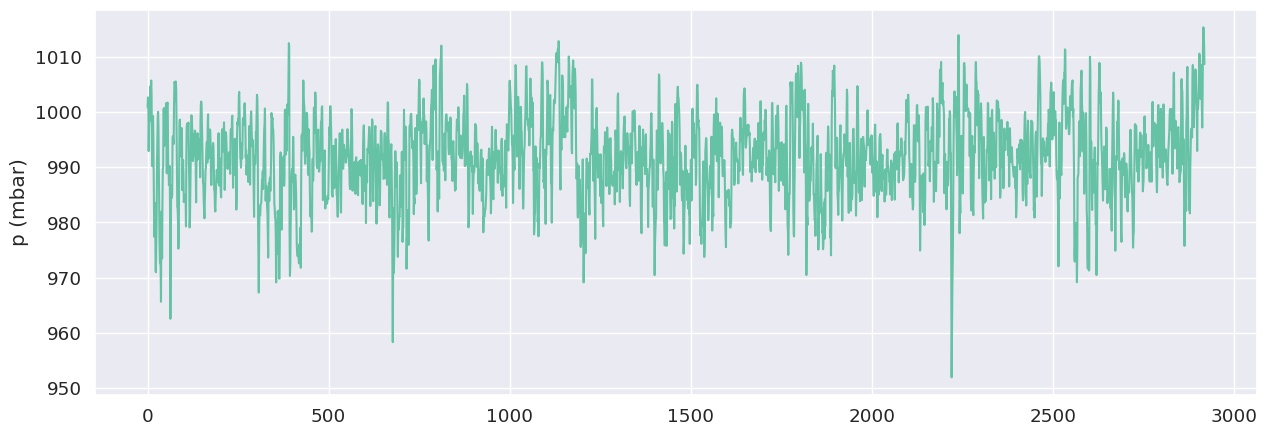

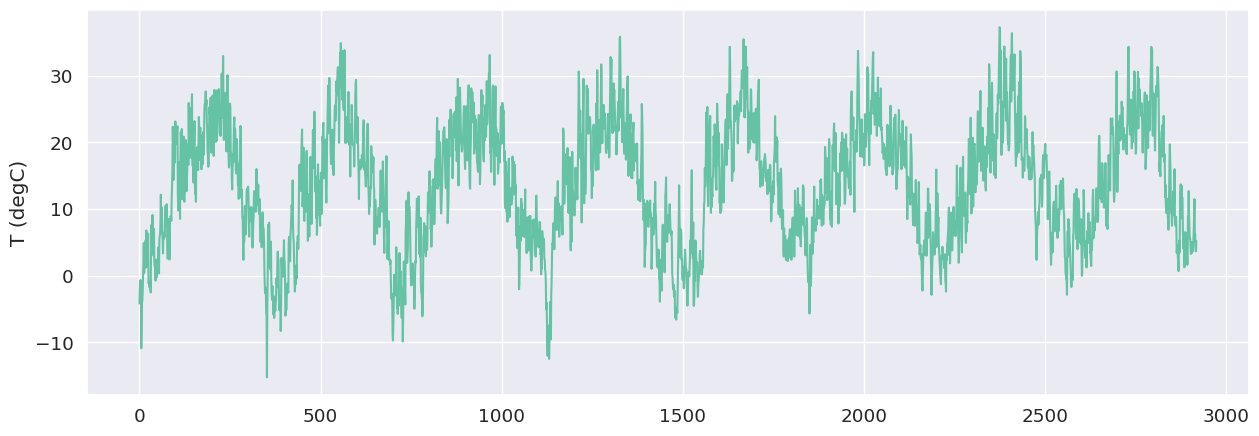

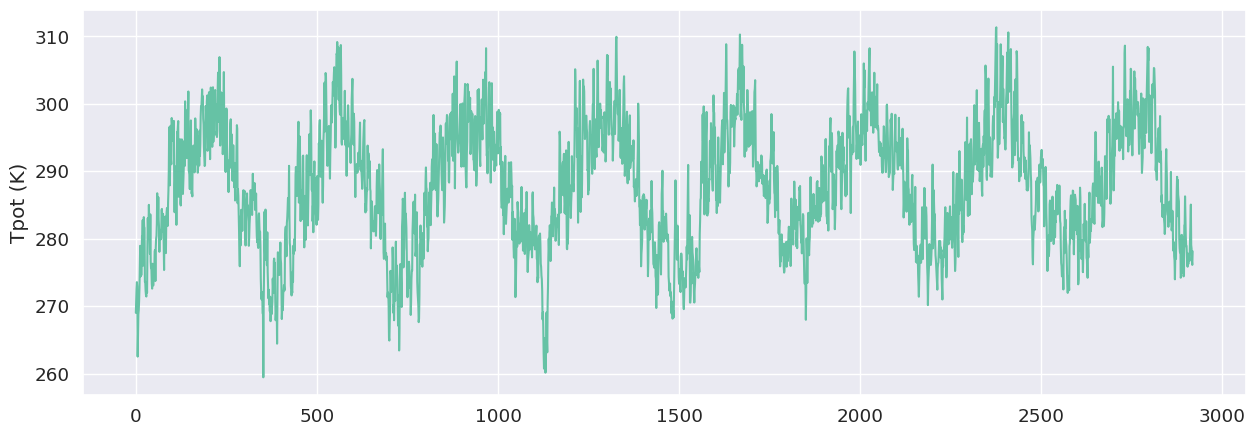

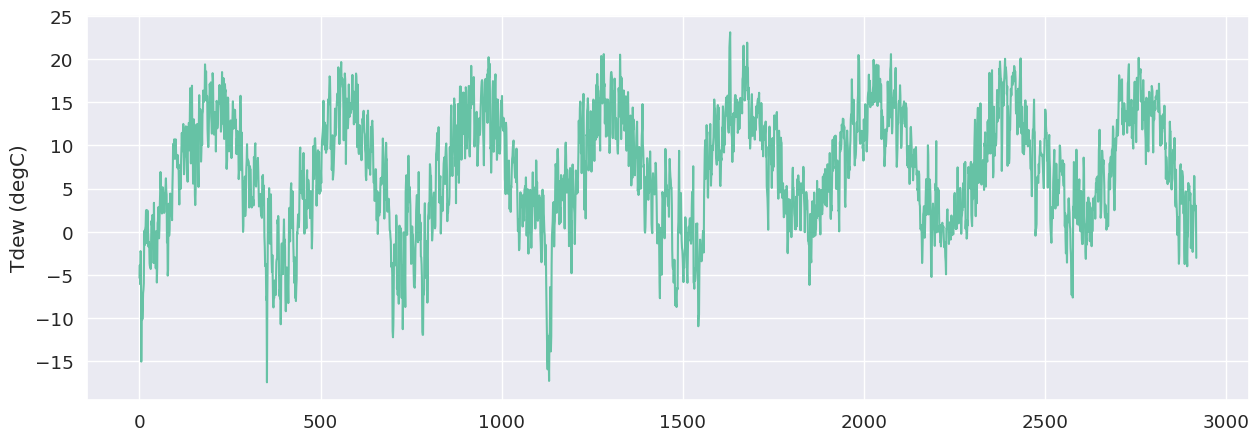

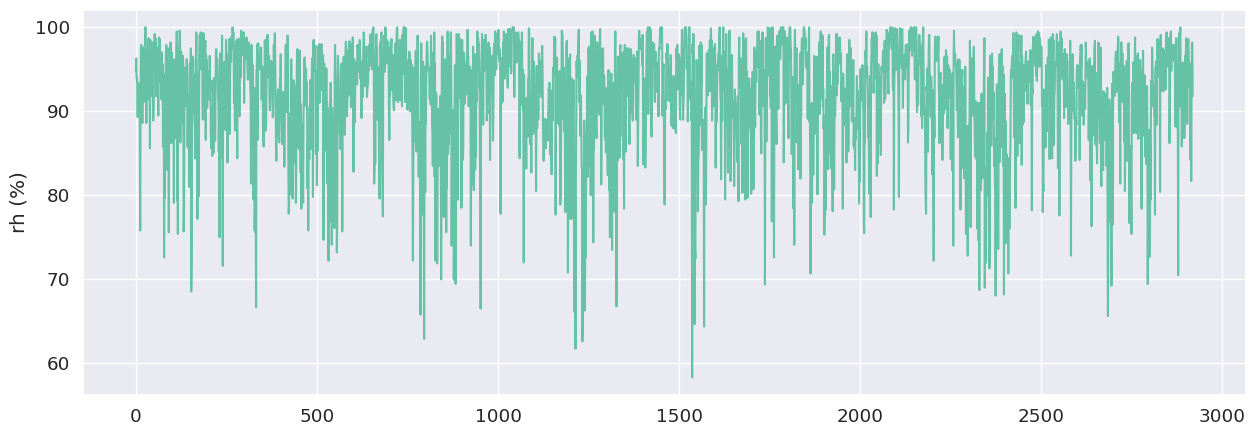

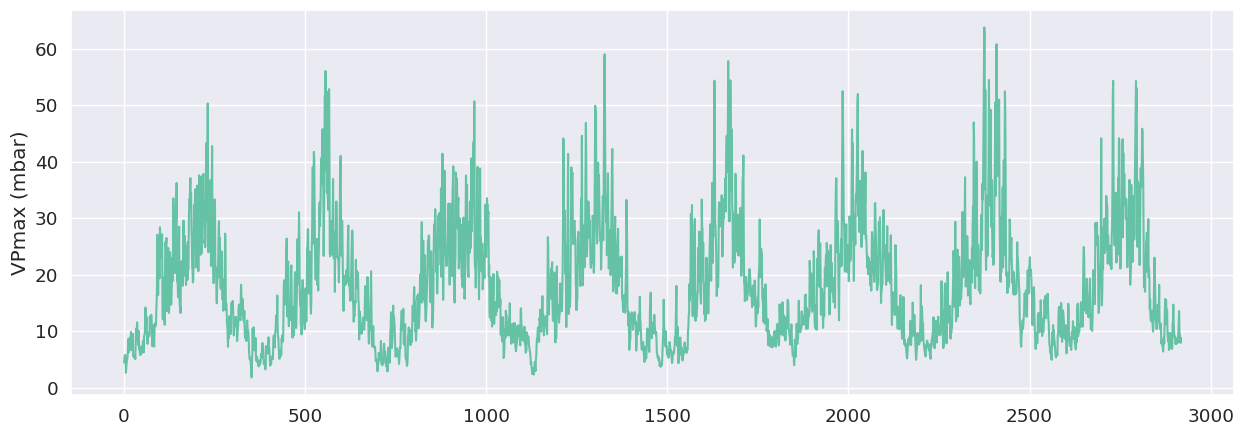

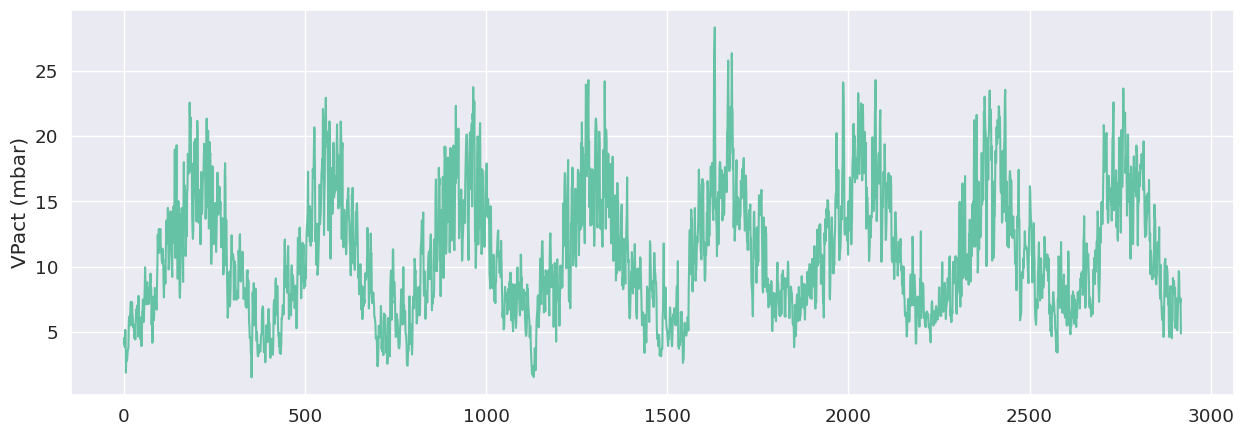

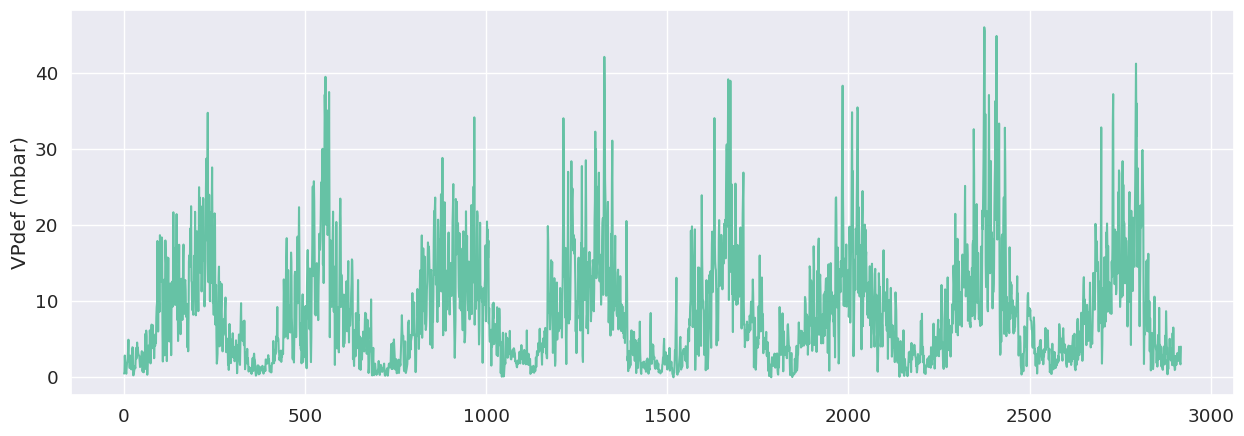

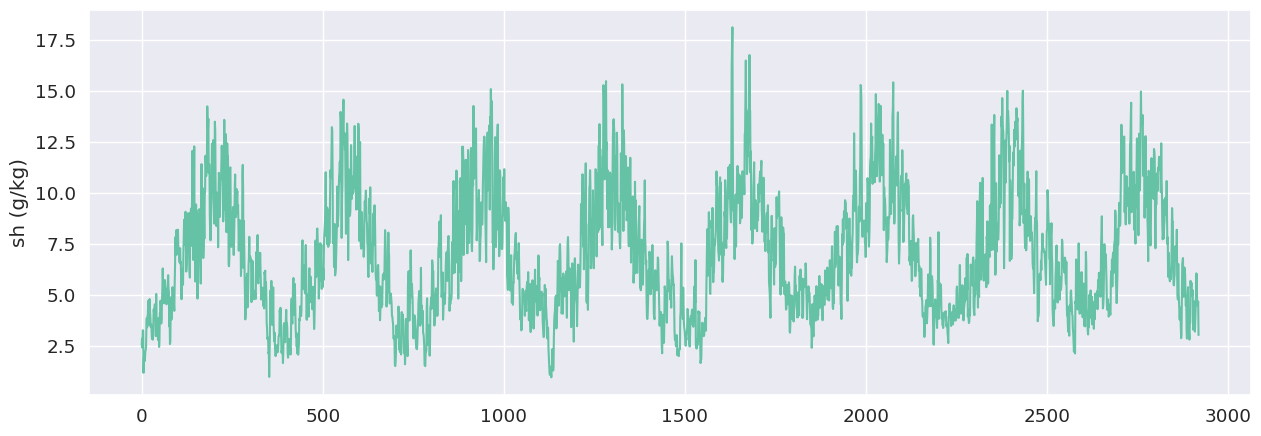

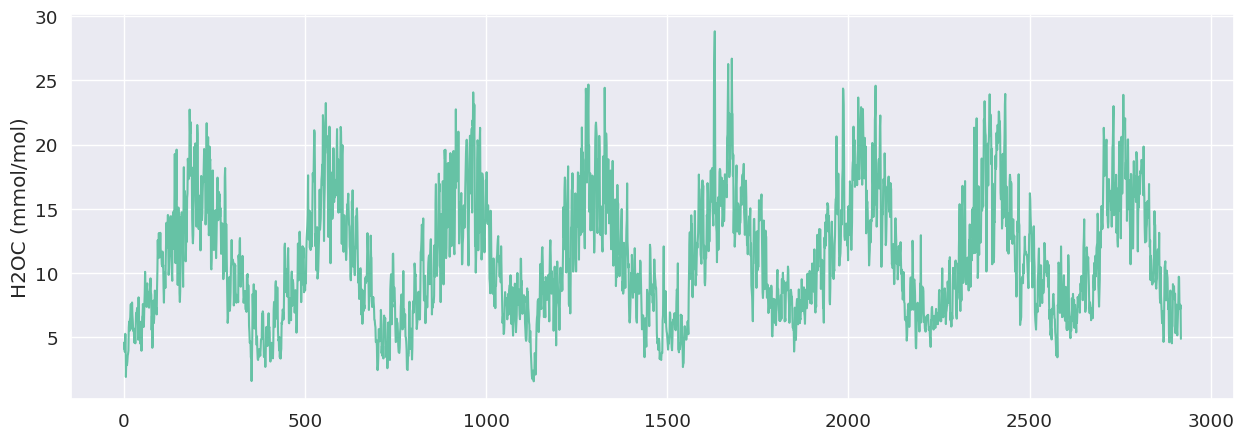

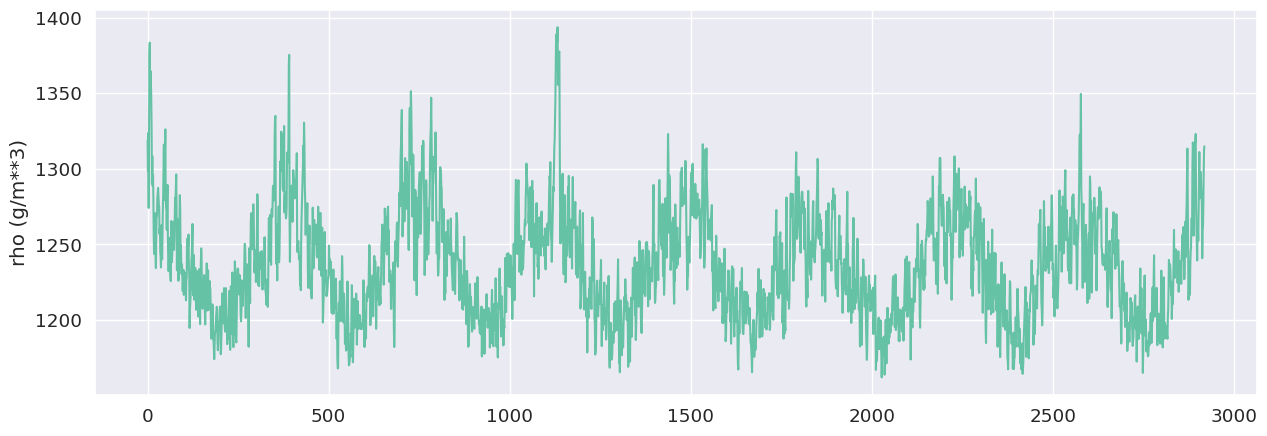

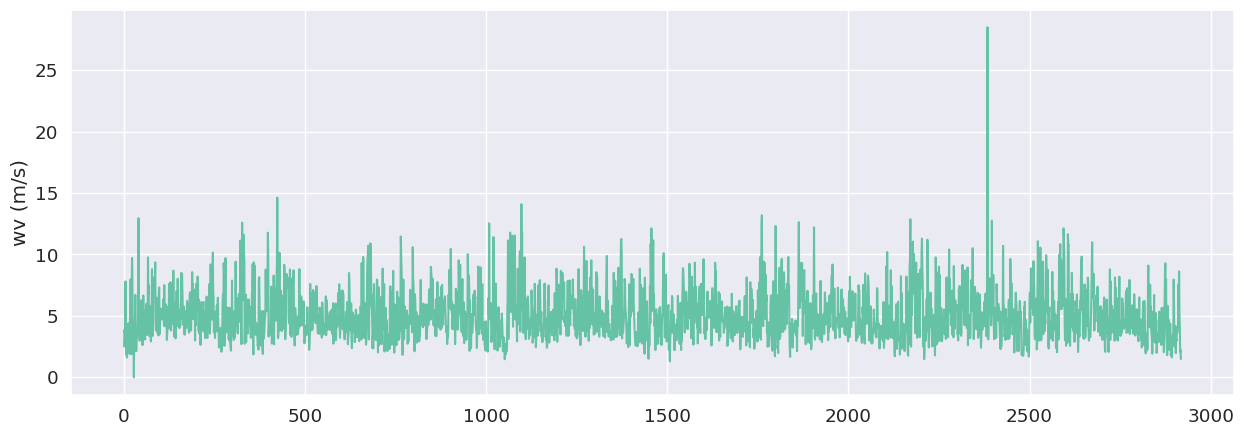

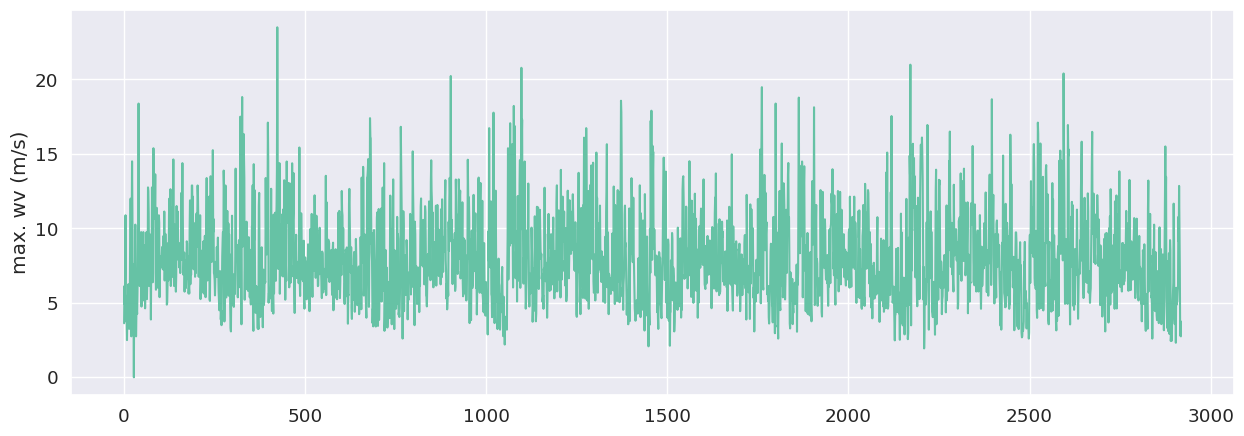

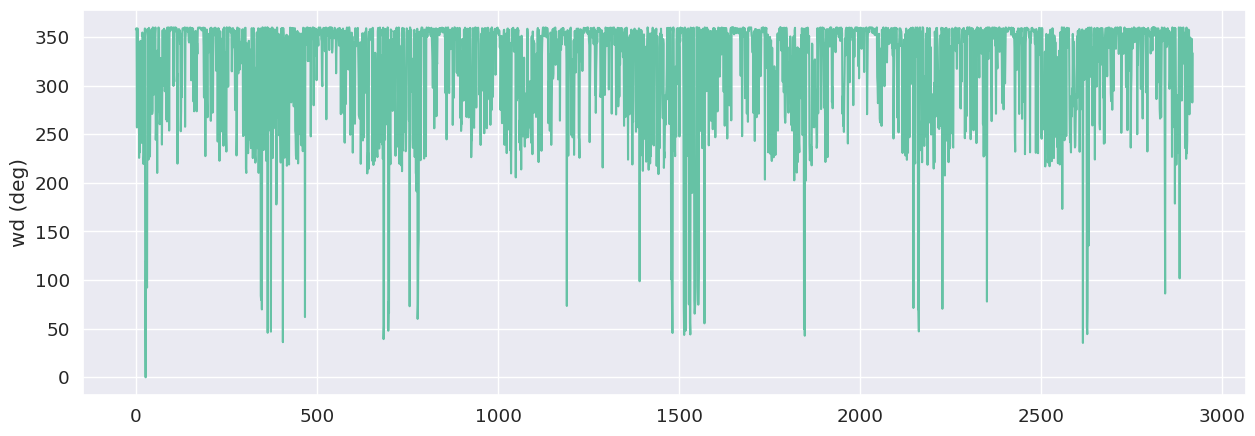

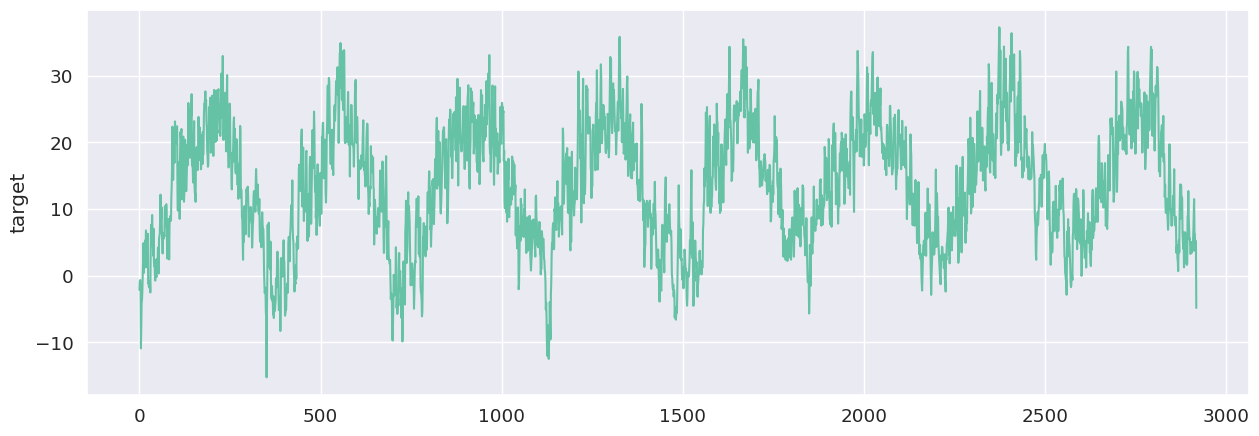

In [70]:
for column in weather_df_daily_good.columns:
  plt.figure(figsize=(15, 5))
  plt.plot(np.array(weather_df_daily_good[column]))
  plt.ylabel(column)
  plt.show()

Для многих рядов видна годичная сезонность, что логично

Видны выбросы. Будем действовать следующим обаразом: по графикам оценивать трешхолд, по которому будет определяться, что данная точка является выбросом. Трешхолды были подобраны так, чтобы за выбросы принимались только самые очевидные точки (около 10 из всей выборки для каждого ряда). Заменять будем средним за предыдущий и следующий дни. Если в те дни значения похожи, то данная точка и не совсем выброс, так что все более менее логично

In [9]:
from datetime import timedelta

In [10]:
def replace_outliers_with_mean(index, col):
  for ind in index:
    ind1 = ind + timedelta(days=1)
    ind2 = ind - timedelta(days=1)
    weather_df_daily_good.loc[ind][col] = (weather_df_daily_good.loc[ind1][col] + weather_df_daily_good.loc[ind2][col]) / 2

In [11]:
len(weather_df_daily_good[weather_df_daily_good['target'] <= -9])

11

In [12]:
replace_outliers_with_mean(weather_df_daily_good[weather_df_daily_good['target'] <= -9].index, 'target')

In [13]:
len(weather_df_daily_good[weather_df_daily_good['target'] <= -9]) # стало меньше, что хорошо

1

In [14]:
replace_outliers_with_mean(weather_df_daily_good[weather_df_daily_good['wd (deg)'] <= 50].index, 'wd (deg)')

In [15]:
replace_outliers_with_mean(weather_df_daily_good[weather_df_daily_good['max. wv (m/s)'] <= 1].index, 'max. wv (m/s)')

In [16]:
replace_outliers_with_mean(weather_df_daily_good[weather_df_daily_good['max. wv (m/s)'] >= 20].index, 'max. wv (m/s)')

In [17]:
replace_outliers_with_mean(weather_df_daily_good[weather_df_daily_good['wv (m/s)'] <= 0.5].index, 'wv (m/s)')

In [18]:
replace_outliers_with_mean(weather_df_daily_good[weather_df_daily_good['wv (m/s)'] >= 15].index, 'wv (m/s)')

In [19]:
replace_outliers_with_mean(weather_df_daily_good[weather_df_daily_good['rho (g/m**3)'] >= 1350].index, 'rho (g/m**3)')

In [20]:
replace_outliers_with_mean(weather_df_daily_good[weather_df_daily_good['H2OC (mmol/mol)'] >= 25].index, 'H2OC (mmol/mol)')

In [21]:
replace_outliers_with_mean(weather_df_daily_good[weather_df_daily_good['sh (g/kg)'] >= 16].index, 'sh (g/kg)')

In [22]:
replace_outliers_with_mean(weather_df_daily_good[weather_df_daily_good['VPdef (mbar)'] >= 40].index, 'VPdef (mbar)')

In [23]:
replace_outliers_with_mean(weather_df_daily_good[weather_df_daily_good['VPact (mbar)'] >= 25].index, 'VPact (mbar)')

In [24]:
replace_outliers_with_mean(weather_df_daily_good[weather_df_daily_good['VPmax (mbar)'] >= 60].index, 'VPmax (mbar)')

In [25]:
replace_outliers_with_mean(weather_df_daily_good[weather_df_daily_good['rh (%)'] <= 65].index, 'rh (%)')

In [26]:
replace_outliers_with_mean(weather_df_daily_good[weather_df_daily_good['Tdew (degC)'] <= -14].index, 'Tdew (degC)')

In [27]:
replace_outliers_with_mean(weather_df_daily_good[weather_df_daily_good['Tpot (K)'] <= 262].index, 'Tpot (K)')

In [28]:
replace_outliers_with_mean(weather_df_daily_good[weather_df_daily_good['T (degC)'] <= -9].index, 'T (degC)')

In [29]:
replace_outliers_with_mean(weather_df_daily_good[weather_df_daily_good['p (mbar)'] <= 965].index, 'p (mbar)')

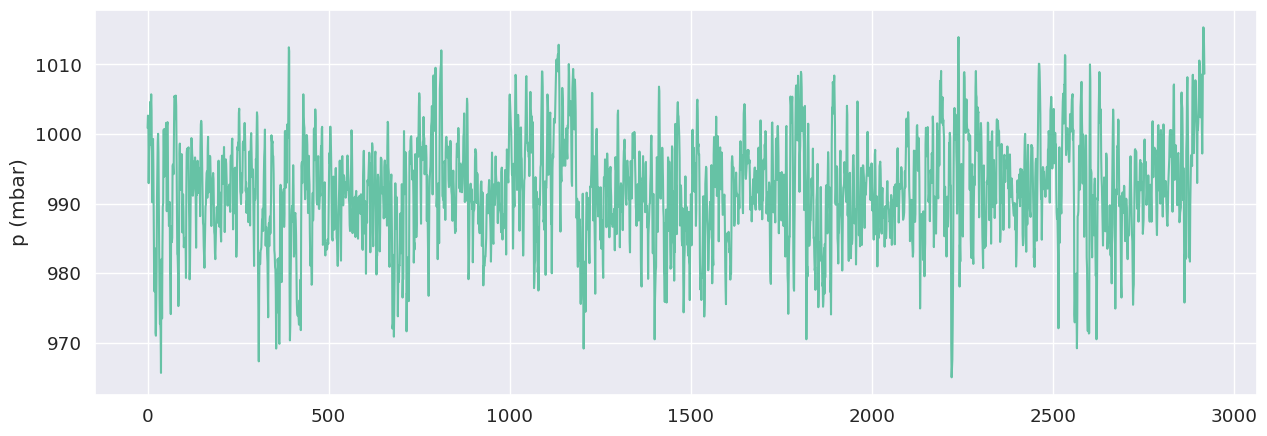

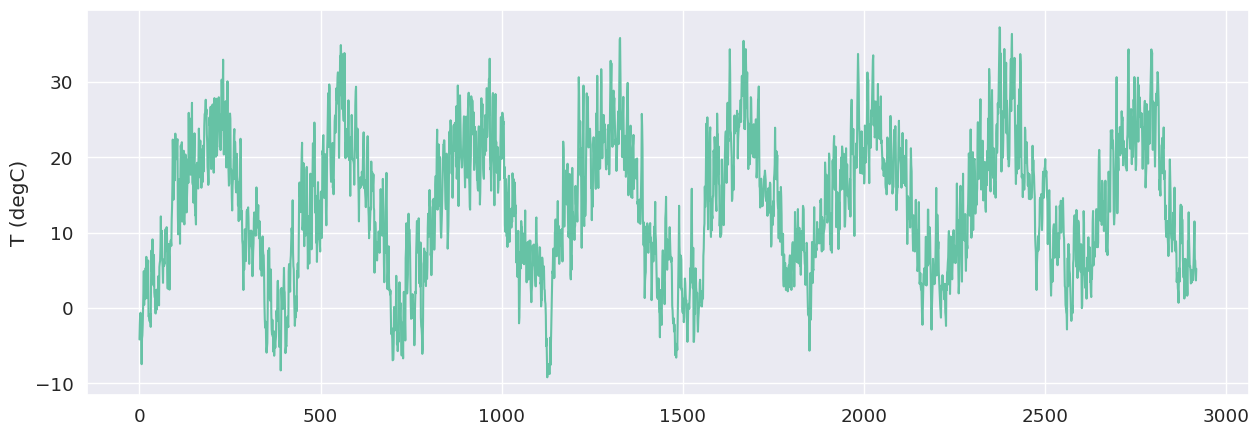

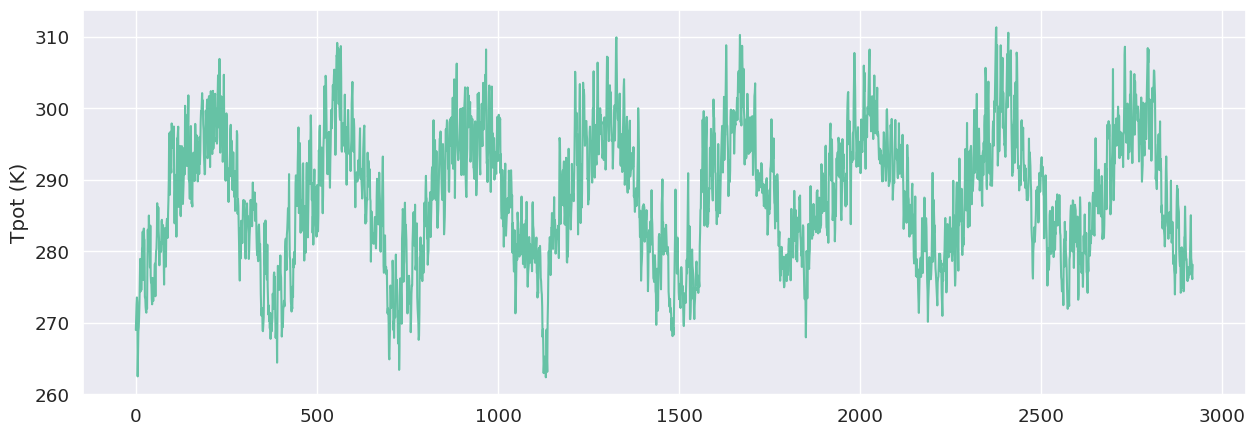

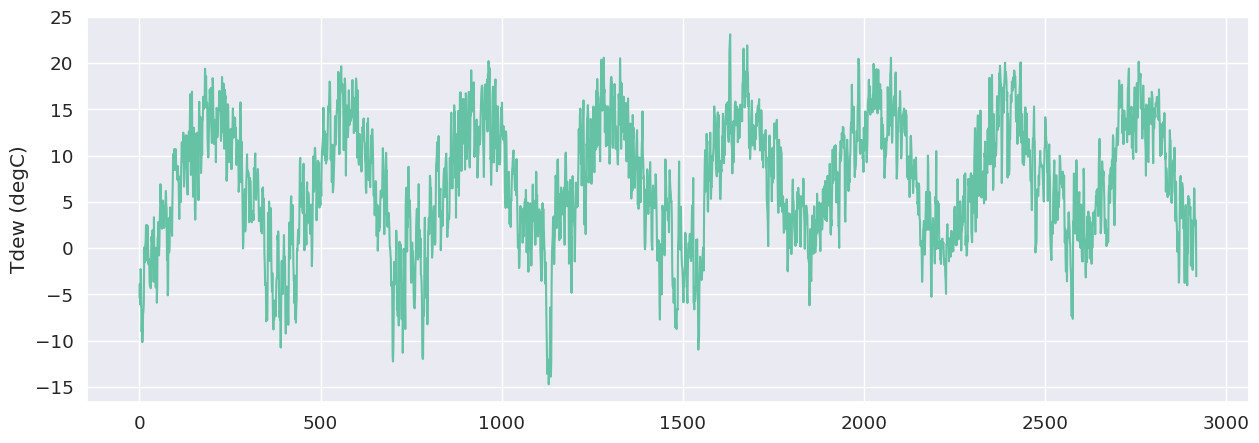

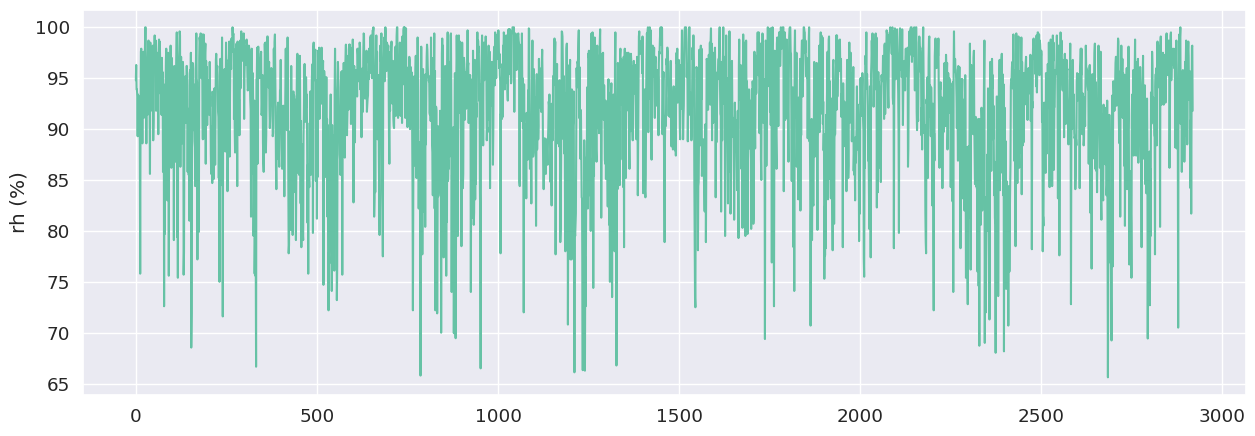

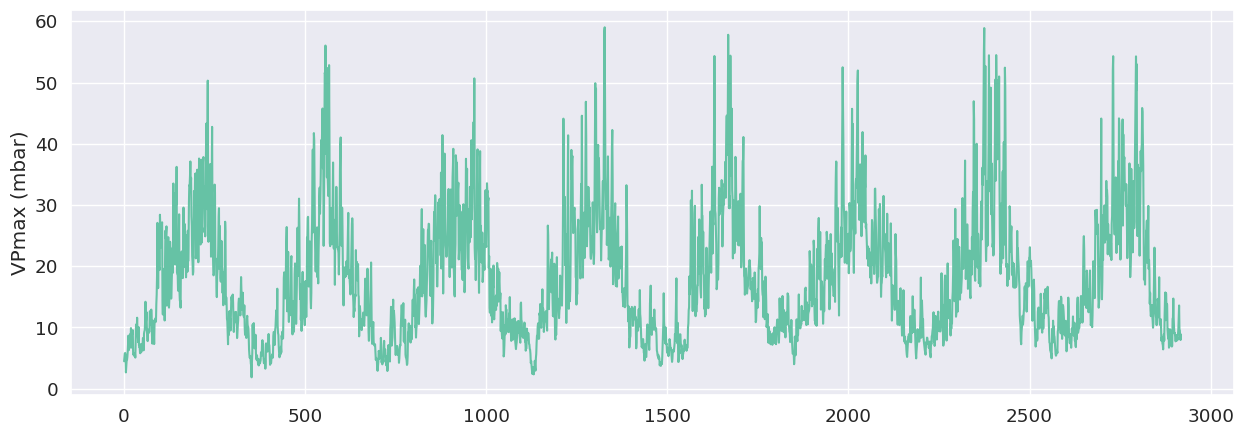

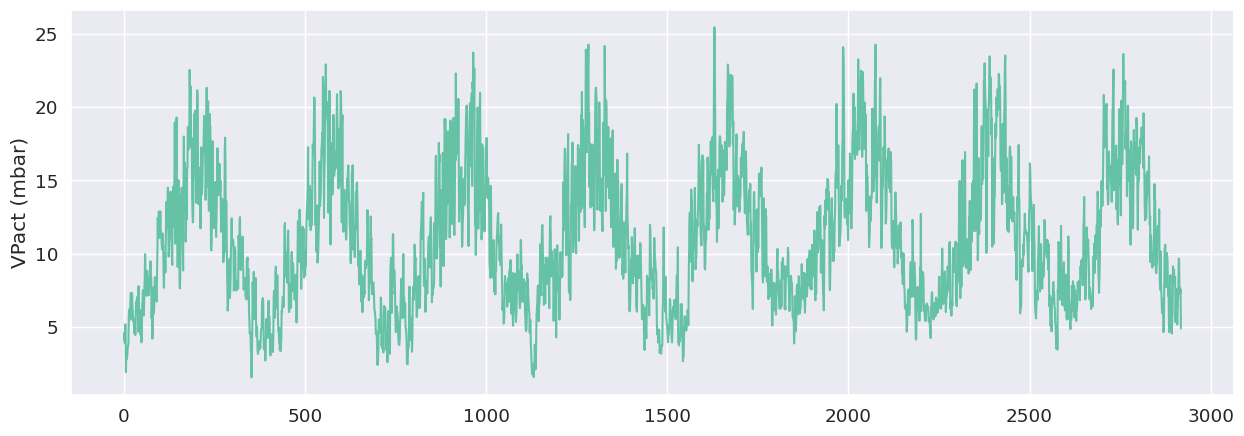

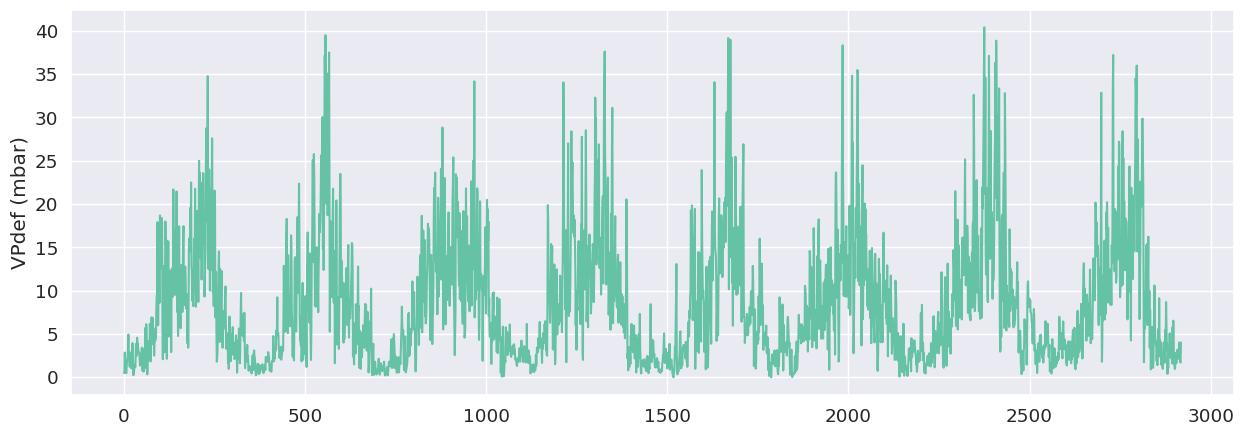

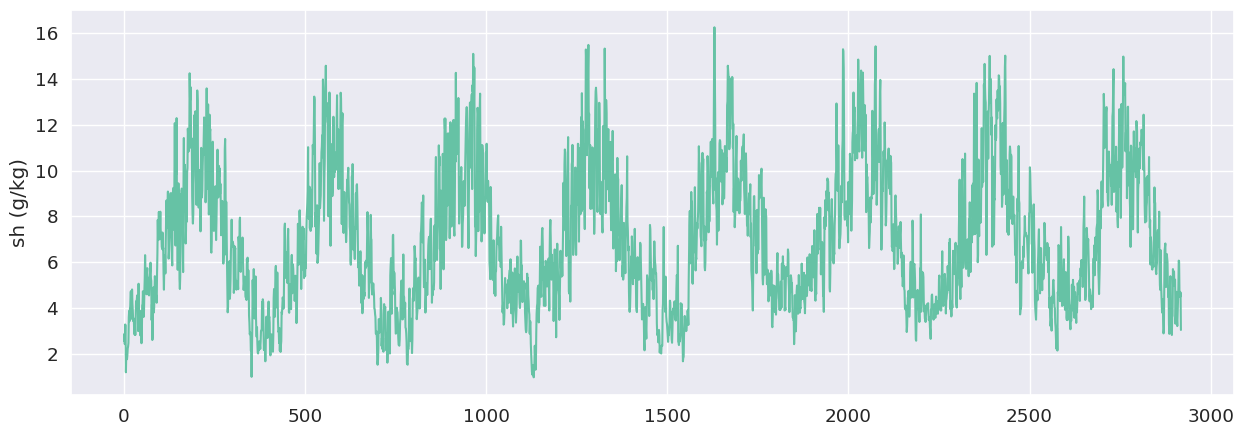

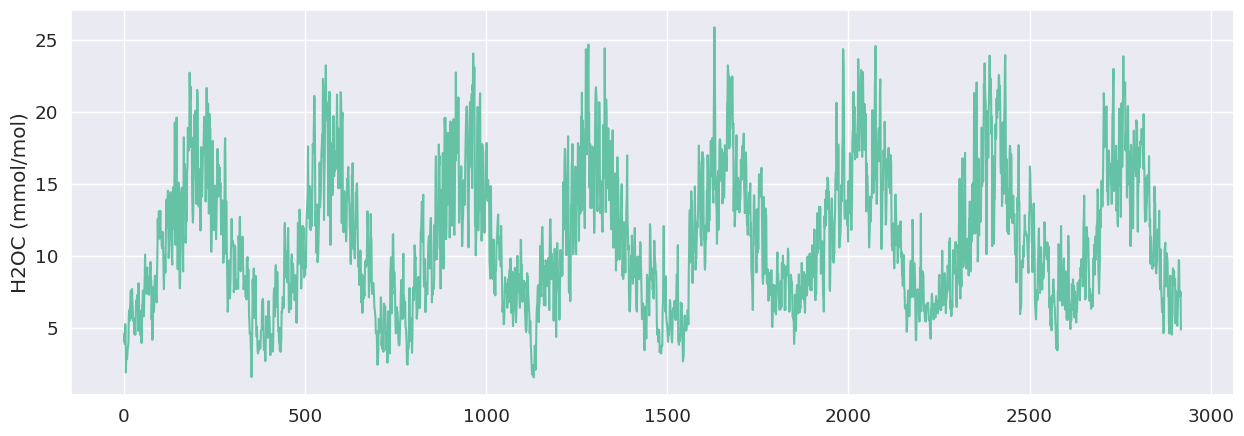

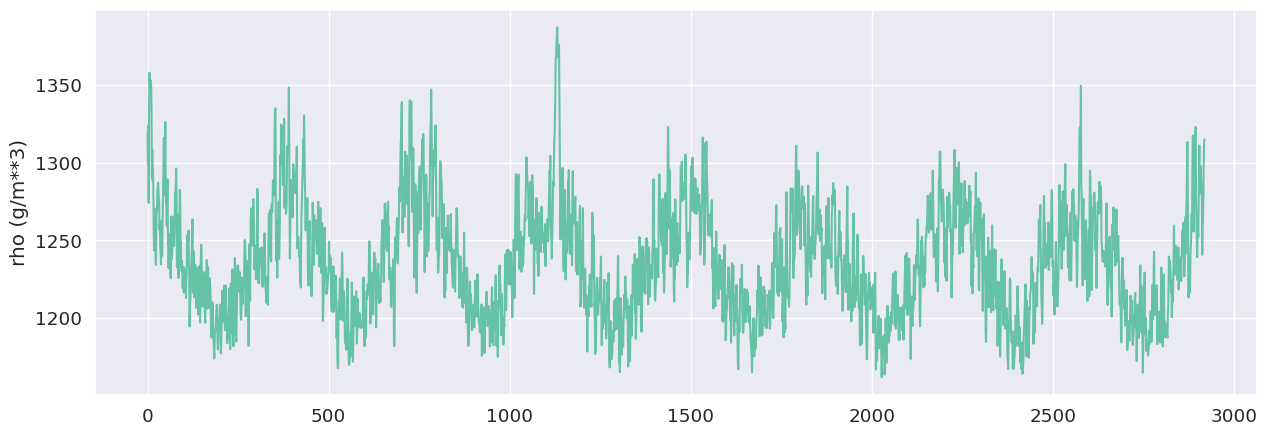

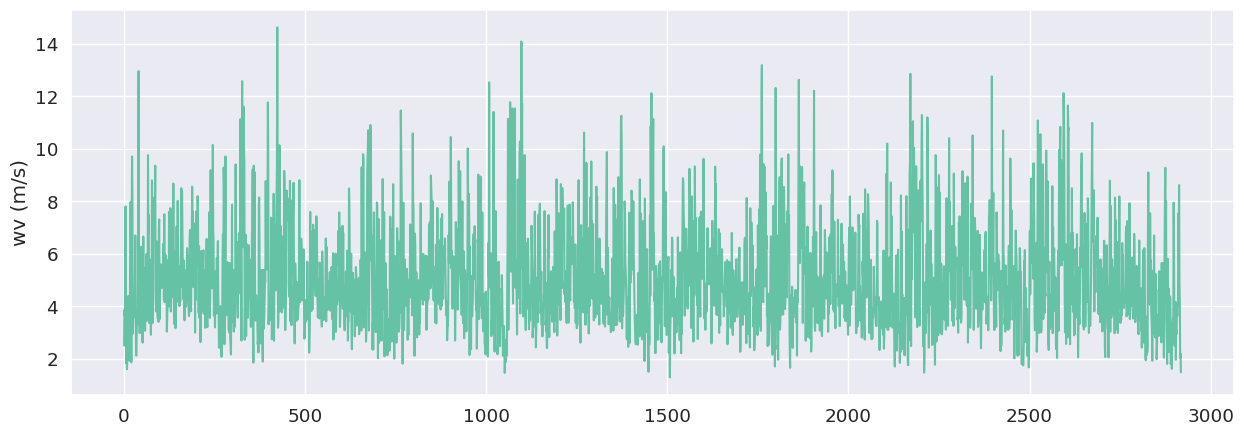

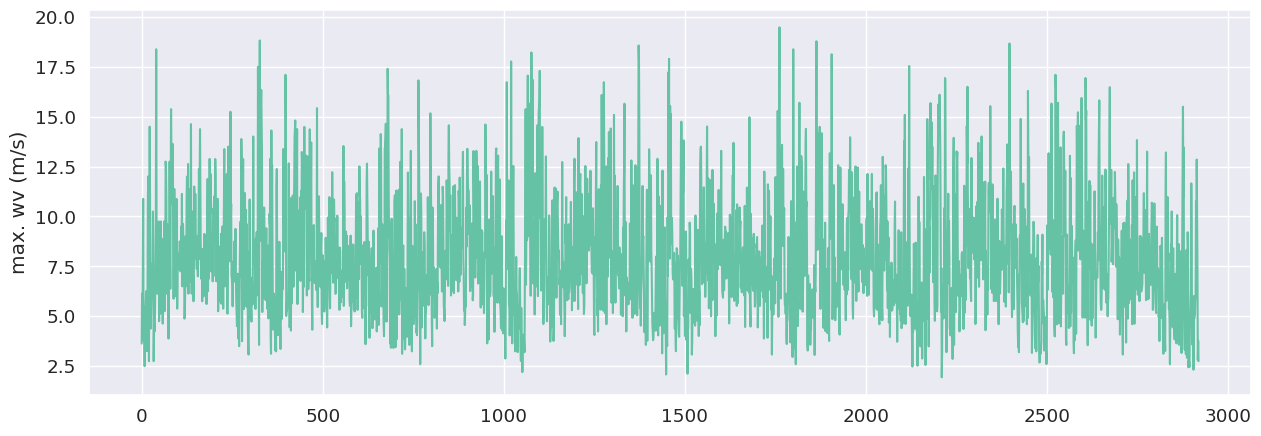

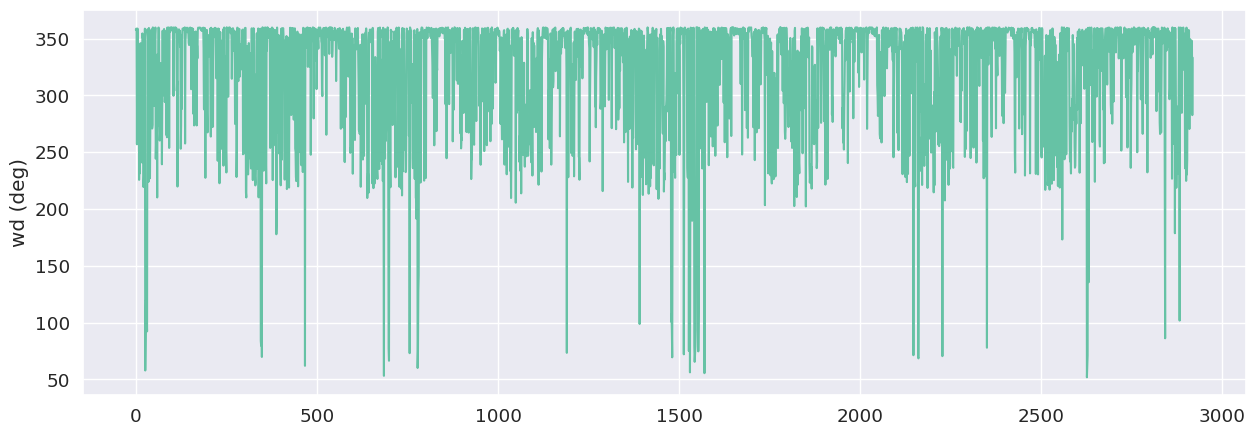

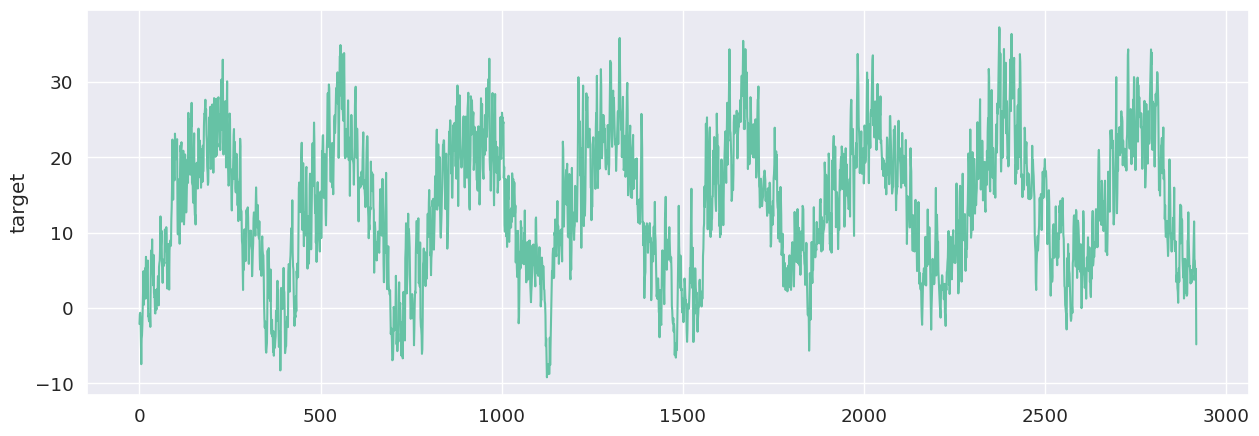

In [68]:
for column in weather_df_daily_good.columns:
  plt.figure(figsize=(15, 5))
  plt.plot(np.array(weather_df_daily_good[column]))
  plt.ylabel(column)
  plt.show()

Стало явно лучше

In [30]:
# Теперь заново разделим на трейн и тест, так как мы немного поменяли данные

X_train, Y_train = weather_df_daily_good[:-365].drop(labels=['target'], axis=1), target[:-365]
X_test, Y_test = weather_df_daily_good[-365:].drop(labels=['target'], axis=1), target[-365:]

Посчитаем матрицу корреляций по всем временным рядам без сдвигов (т.е. $corr(x_t, y_t)$) и визуализируем ее

In [30]:
weather_df_daily_good.drop(labels=['target'], axis=1).corr()

p (mbar)  T (degC)  Tpot (K)  Tdew (degC)    rh (%)  \
p (mbar)         1.000000 -0.030295 -0.102363    -0.095605 -0.022625   
T (degC)        -0.030295  1.000000  0.996955     0.909510 -0.168404   
Tpot (K)        -0.102363  0.996955  1.000000     0.911057 -0.166779   
Tdew (degC)     -0.095605  0.909510  0.911057     1.000000  0.050393   
rh (%)          -0.022625 -0.168404 -0.166779     0.050393  1.000000   
VPmax (mbar)    -0.024867  0.958464  0.955658     0.842280 -0.188102   
VPact (mbar)    -0.090943  0.889185  0.890315     0.972905  0.047415   
VPdef (mbar)     0.012789  0.881654  0.877222     0.666478 -0.299037   
sh (g/kg)       -0.106223  0.887146  0.889549     0.972088  0.047777   
H2OC (mmol/mol) -0.106235  0.887551  0.889952     0.972544  0.047763   
rho (g/m**3)     0.383080 -0.829532 -0.851006    -0.901510  0.117599   
wv (m/s)        -0.244534  0.059853  0.085882     0.055073 -0.248902   
max. wv (m/s)   -0.242744  0.121067  0.147538     0.102391 -0.296148   
wd (deg)         0.096144  0.270290  0.260019     0.266001  0.045679   

                 VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
p (mbar)            -0.024867     -0.090943      0.012789  -0.106223   
T (degC)             0.958464      0.889185      0.881654   0.887146   
Tpot (K)             0.955658      0.890315      0.877222   0.889549   
Tdew (degC)          0.842280      0.972905      0.666478   0.972088   
rh (%)              -0.188102      0.047415     -0.299037   0.047777   
VPmax (mbar)         1.000000      0.871446      0.949928   0.869891   
VPact (mbar)         0.871446      1.000000      0.693691   0.999826   
VPdef (mbar)         0.949928      0.693691      1.000000   0.691727   
sh (g/kg)            0.869891      0.999826      0.691727   1.000000   
H2OC (mmol/mol)      0.869856      0.999832      0.691671   0.999997   
rho (g/m**3)        -0.764601     -0.867998     -0.612528  -0.871357   
wv (m/s)             0.031033      0.035763      0.038710   0.041811   
max. wv (m/s)        0.086557      0.078216      0.104044   0.084385   
wd (deg)             0.248759      0.263704      0.215020   0.261462   

                 H2OC (mmol/mol)  rho (g/m**3)  wv (m/s)  max. wv (m/s)  \
p (mbar)               -0.106235      0.383080 -0.244534      -0.242744   
T (degC)                0.887551     -0.829532  0.059853       0.121067   
Tpot (K)                0.889952     -0.851006  0.085882       0.147538   
Tdew (degC)             0.972544     -0.901510  0.055073       0.102391   
rh (%)                  0.047763      0.117599 -0.248902      -0.296148   
VPmax (mbar)            0.869856     -0.764601  0.031033       0.086557   
VPact (mbar)            0.999832     -0.867998  0.035763       0.078216   
VPdef (mbar)            0.691671     -0.612528  0.038710       0.104044   
sh (g/kg)               0.999997     -0.871357  0.041811       0.084385   
H2OC (mmol/mol)         1.000000     -0.871820  0.041938       0.084541   
rho (g/m**3)           -0.871820      1.000000 -0.163608      -0.218111   
wv (m/s)                0.041938     -0.163608  1.000000       0.918961   
max. wv (m/s)           0.084541     -0.218111  0.918961       1.000000   
wd (deg)                0.261556     -0.191545 -0.274447      -0.248010   

                 wd (deg)  
p (mbar)         0.096144  
T (degC)         0.270290  
Tpot (K)         0.260019  
Tdew (degC)      0.266001  
rh (%)           0.045679  
VPmax (mbar)     0.248759  
VPact (mbar)     0.263704  
VPdef (mbar)     0.215020  
sh (g/kg)        0.261462  
H2OC (mmol/mol)  0.261556  
rho (g/m**3)    -0.191545  
wv (m/s)        -0.274447  
max. wv (m/s)   -0.248010  
wd (deg)         1.000000

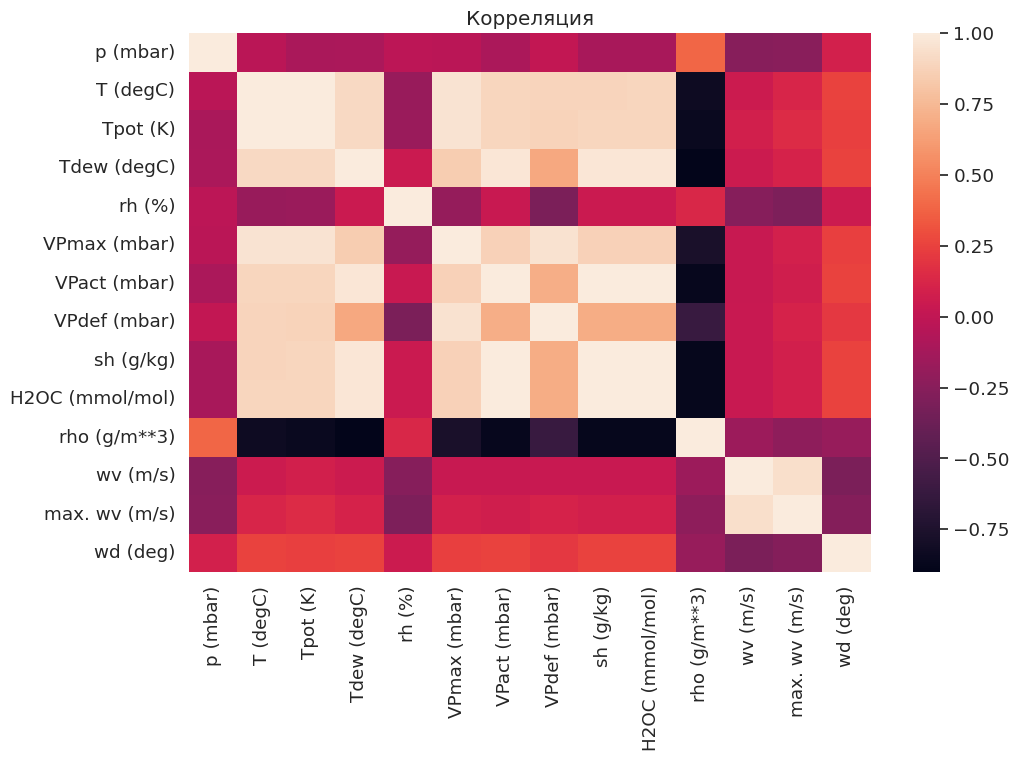

In [91]:
# Визуализация:

sns.heatmap(weather_df_daily_good.drop(labels=['target'], axis=1).corr());
plt.title("Корреляция")
plt.show()

Итого температура сильно коррелирует аж с восьмью другими признаками (и еще с одним, но там отрицательная корреляция, но большая по модулю, что тоже дает нам информацию)

Построим коррелограмму временного ряда температуры

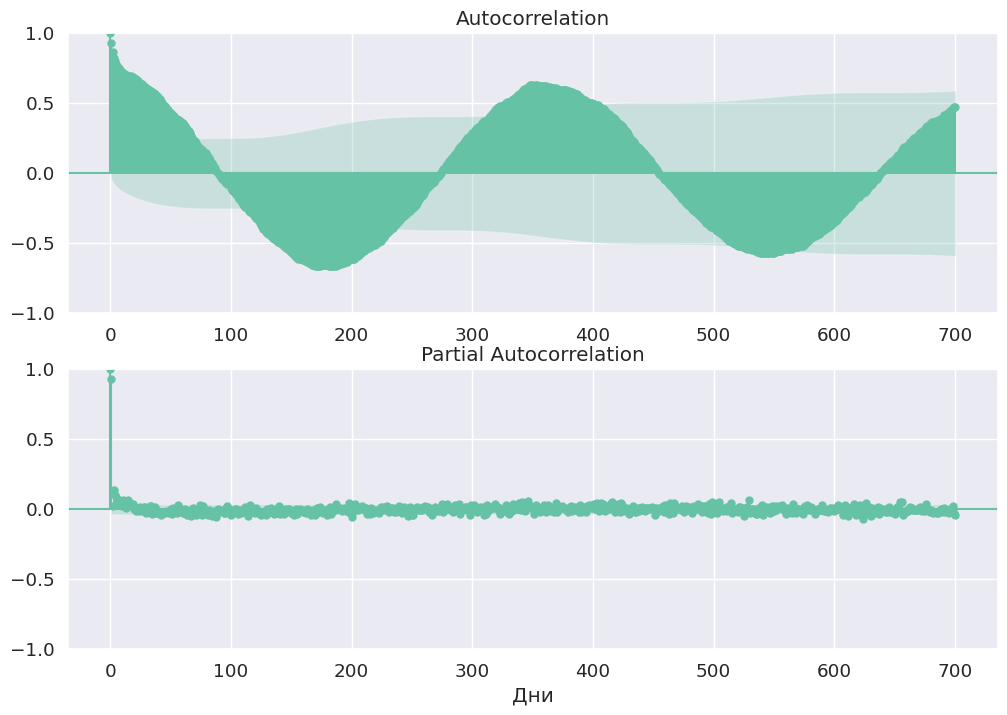

In [93]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(target.values.squeeze(), lags=700, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(target, lags=700, ax=ax2)
plt.xlabel('Дни')
plt.show()

По таким графикам сразу видна сезонность. Во-первых, пик есть где-то вблизи точки 365, что логично. Во-вторых, можно заметить минимум в точке ~180. Это объясняется тем, что температура летом и зимой отличается больше всего

По временному ряду температуры выполним STL-разложение и визуализирум полученные компоненты

In [56]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL

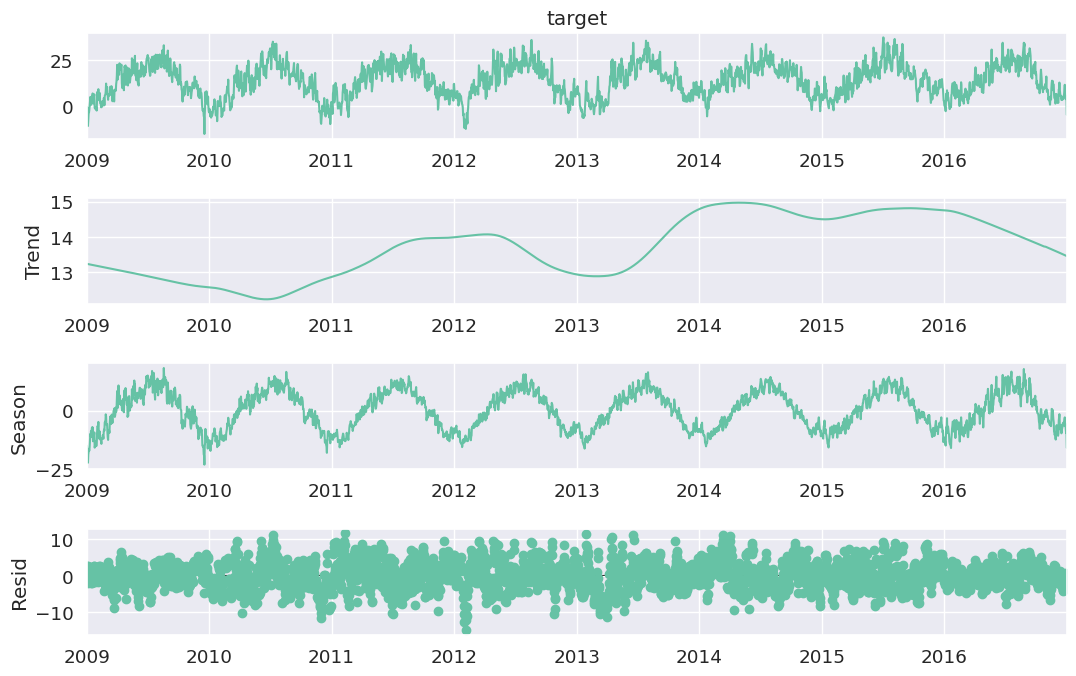

In [67]:
import statsmodels

result = STL(target, period=365).fit()
fig = result.plot()
fig.show()

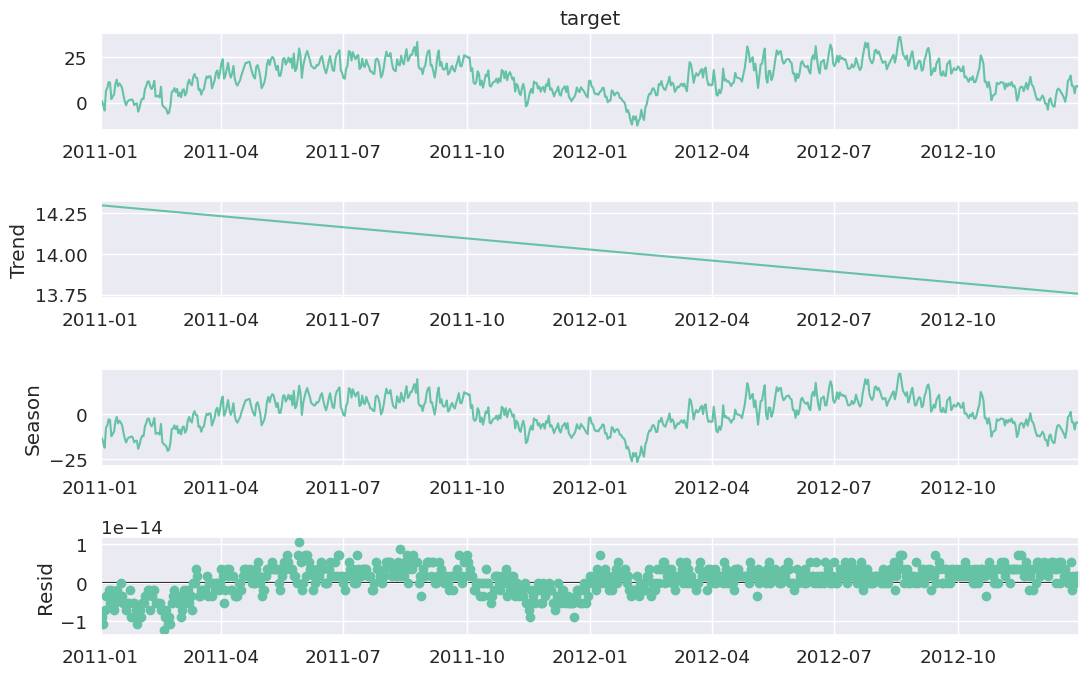

In [66]:
# Чуть поближе посмотрим

result = STL(target[365 * 2:365 * 4], period=365).fit()
fig = result.plot()
fig.show()

**Выводы:** В данных есть небольшой вначале нисходящий, потом восходящий тренд. Также видна сезонность длиной в год. Остатки в целом похожи на нормальные 

## 3. Качество

Буду считать SMAPE, а не MAPE, так как температура бывает близкой к нулю и выходят слишком большие значения MAPE

In [46]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

Функция для добавления скоров в общую табличку

In [47]:
import statistics

compare_table = None

def add_results_in_comparison_table(method: str, y_true, y_forecast) -> pd.DataFrame:
    """
    Добавляет новую строчку в таблицу compare_table с результатами текущей модели.
    Если ранее модель была уже добавлена в таблицу, то старая строчка перезапишется на новую.
    
    Параметры:
    - method: имя модели.
    - y_true: истинные значения.
    - y_forecast: предсказанные значения.
    """
    
    # Обращаемся к глобальной переменной
    global compare_table
    
    # Считаем метрики
    result_row = {
        'method': method,
        "MSE": mean_squared_error(y_true=y_true, y_pred=y_forecast),
        "MAE": mean_absolute_error(y_true=y_true, y_pred=y_forecast),
        "SMAPE": SMAPE(y_forecast, y_true),
        "MedAE": median_absolute_error(y_forecast, y_true)
    }
    
    # Записываем результат в таблицу
    if compare_table is None:
        compare_table = pd.DataFrame([result_row])
    else:
        if method in list(compare_table['method']):
            compare_table = compare_table[compare_table['method'] != method]

        compare_table = pd.concat([compare_table, pd.DataFrame([result_row])])
        compare_table.index = np.arange(len(compare_table))
    return compare_table

def SMAPE(y_true, y_pred):
  return np.mean(
            np.abs(y_pred - y_true) / 
            ((np.abs(y_pred) + np.abs(y_true))/2)
        )*100

def mean_absolute_percentage_error(y_true, y_pred) -> float: 
    """Считает MAPE для y_true и y_pred"""
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true[np.abs(y_true) < 0.1] = 1
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def median_absolute_error(pred, true):
    return statistics.median(abs(pred - true)) 

По всем данным посчитаем метрики качества baseline-решения &mdash; прогноз константой (т.е. прогноз последним доступным значением самой прогнозируемой величины), для горизонтов прогнозирования 1, 2, 3.

In [48]:
# Для горизонта 1:
preds = weather_df_daily_good['T (degC)'] # Как раз все смещено на 1

In [49]:
# Добавляем в табличку

add_results_in_comparison_table('baseline_horizon_1', weather_df_daily_good['target'], preds)

method        MSE       MAE      SMAPE  MedAE
0  baseline_horizon_1  11.368181  2.583306  30.244208   2.07

In [50]:
# Функция для отрисовки предсказаний

def plot_results(y_true, y_forecast, plot_conf_int=True,
                 left_bound=None, right_bound=None):

    plt.figure(figsize=(15, 5))
    plt.title('Максимальная температура воздуха', fontsize=15)
    plt.plot(y_true, label='true')
    plt.plot(y_true.index, y_forecast, label='prediction')
    if plot_conf_int:
        plt.fill_between(y_true.index, 
                         left_bound, right_bound, 
                         alpha=0.3, color='grey',
                         label='conf.int')
    plt.legend()
    plt.show()

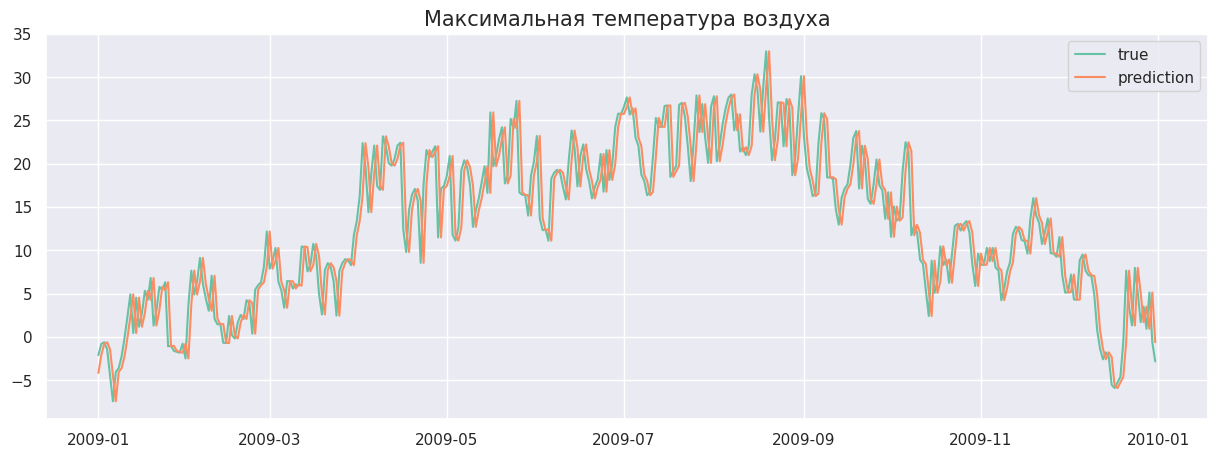

In [59]:
plot_results(weather_df_daily_good['target'][:365], preds[:365], plot_conf_int=False) # Взял предсказания за один год, чтобы была видна разница между true и pred

Видно смещение на один. Может показаться, что в целом похоже, но это не так

In [51]:
# Для горизонта 2:
preds1 = []
i = 0
while i < len(weather_df_daily_good):
    preds1.append(weather_df_daily_good['T (degC)'][i])
    preds1.append(weather_df_daily_good['T (degC)'][i])
    i += 2
preds1.pop()

5.21

In [52]:
add_results_in_comparison_table('baseline_horizon_2', weather_df_daily_good['target'], preds1)

method        MSE       MAE      SMAPE  MedAE
0  baseline_horizon_1  11.368181  2.583306  30.244208   2.07
1  baseline_horizon_2  16.734771  3.136148  35.871218   2.44

Качество ухудшилось по всем фронтам, так как горизонт прогнозирования стал больше

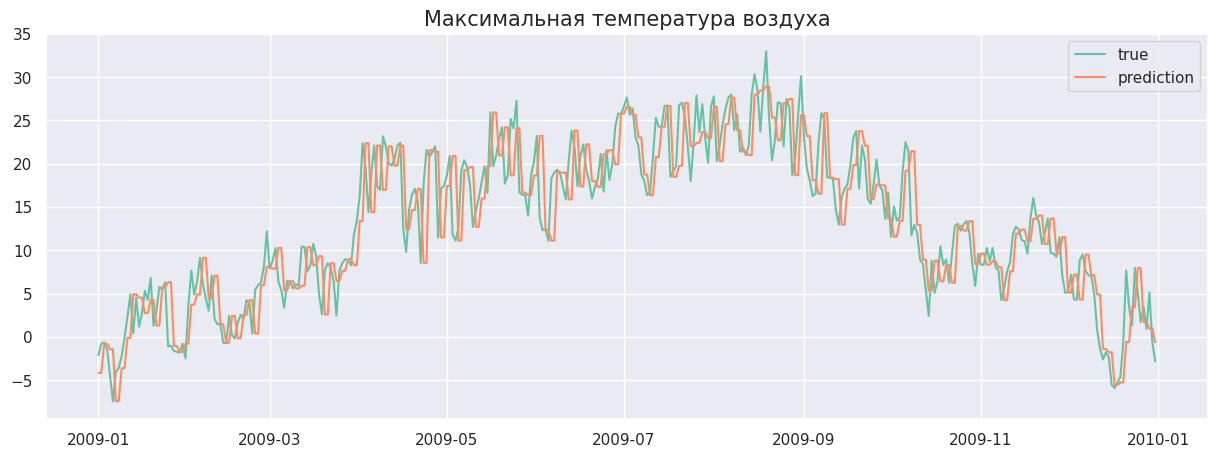

In [68]:
plot_results(weather_df_daily_good['target'][:365], preds1[:365], plot_conf_int=False)

In [53]:
# Для горизонта 3:
preds2 = []
i = 0
while i < len(weather_df_daily_good):
    preds2.append(weather_df_daily_good['T (degC)'][i])
    preds2.append(weather_df_daily_good['T (degC)'][i])
    preds2.append(weather_df_daily_good['T (degC)'][i])
    i += 3

In [54]:
add_results_in_comparison_table('baseline_horizon_3', weather_df_daily_good['target'], preds2)

method        MSE       MAE      SMAPE  MedAE
0  baseline_horizon_1  11.368181  2.583306  30.244208   2.07
1  baseline_horizon_2  16.734771  3.136148  35.871218   2.44
2  baseline_horizon_3  19.968890  3.467079  39.257602   2.74

Как и должно было быть, качество ухудшилось, так как при бОльшем горизонте прогнозирования у нас больше вероятность ошибиться (да и накопление ошибки идет)

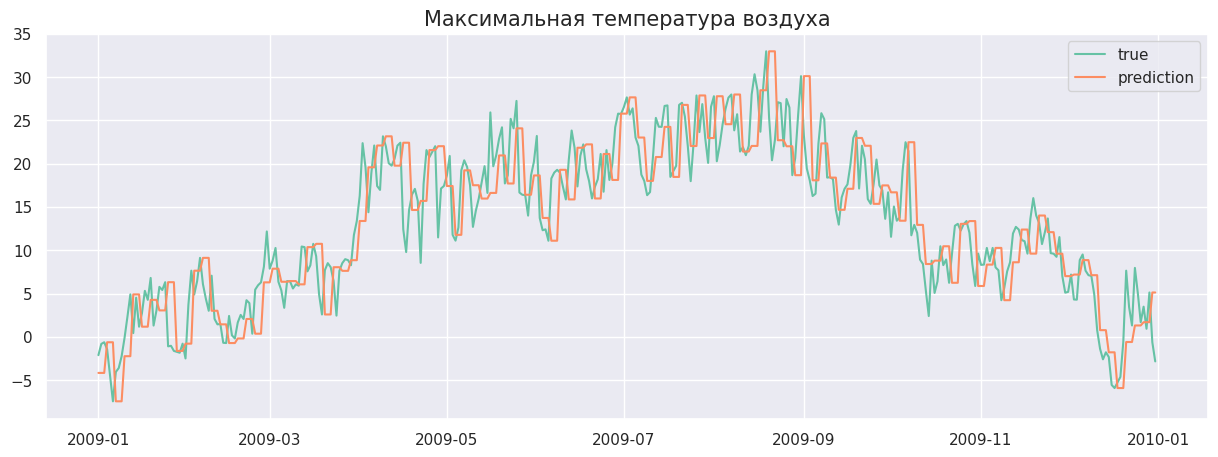

In [77]:
plot_results(weather_df_daily_good['target'][:365], preds2[:365], plot_conf_int=False)

Посчитаем эти же метрики по скользящим окнам из 4 и 8 недель. Иначе говоря, 
* сначала считаете качество по окну $[t+1, t+\Delta t]$, используя в качестве прогноза $y_t$,
* затем по окну $[t+2, t+\Delta t+1]$, используя в качестве прогноза $y_{t+1}$,
* и так далее.

Построим графики изменения качества прогноза со временем.

In [40]:
# Функция для подсчета качества по окну

def window(preds, window):
    mse = []
    mae = []
    mape =[]
    medae = []
    for t in range(len(preds) - window):
        pred = [preds[t + i] for i in range(window)]
        mse.append(mean_squared_error(pred, target[t:(t + window)]))
        mae.append(mean_absolute_error(pred, target[t:(t + window)]))
        mape.append(SMAPE(pred, target[t:(t + window)]))
        medae.append(median_absolute_error(pred, target[t:(t + window)]))
    return mse, mae, smape, medae 

Считаем лосс по окнам и визуализируем

In [98]:
mse, mae, smape, medae = window(preds, 28) 

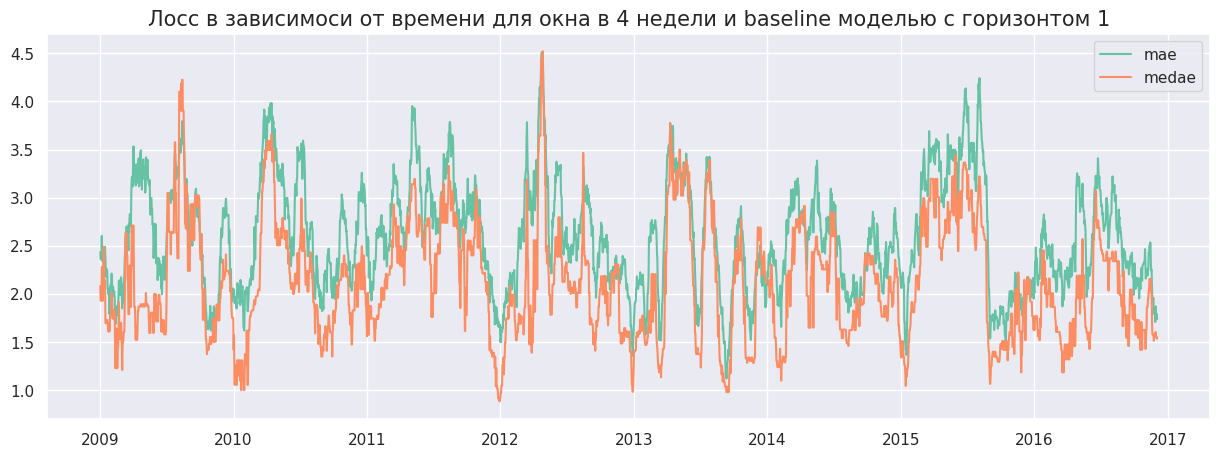

In [101]:
plt.figure(figsize=(15, 5))
plt.title('Лосс в зависимоси от времени для окна в 4 недели и baseline моделью с горизонтом 1', fontsize=15)
plt.plot(weather_df_daily_good['T (degC)'].index[:-28], mae, label='mae')
plt.plot(weather_df_daily_good['T (degC)'].index[:-28], medae, label='medae')
plt.legend()
plt.show()

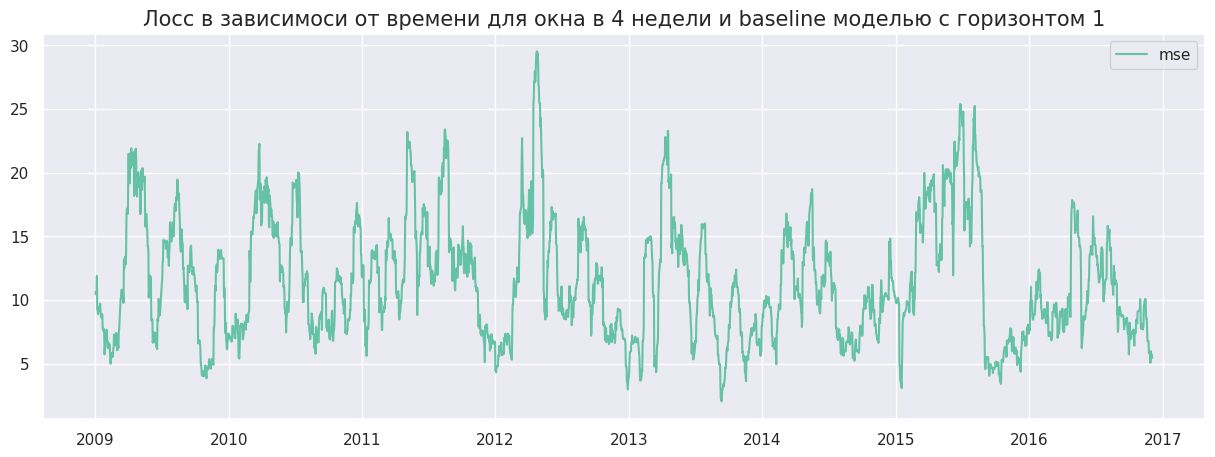

In [102]:
plt.figure(figsize=(15, 5))
plt.title('Лосс в зависимоси от времени для окна в 4 недели и baseline моделью с горизонтом 1', fontsize=15)
plt.plot(weather_df_daily_good['T (degC)'].index[:-28], mse, label='mse')
plt.legend()
plt.show()

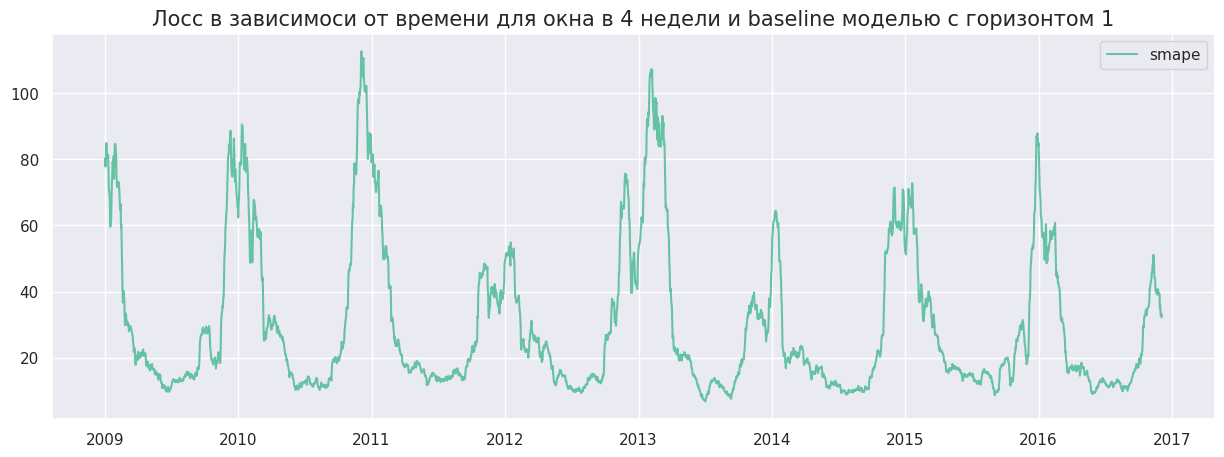

In [103]:
plt.figure(figsize=(15, 5))
plt.title('Лосс в зависимоси от времени для окна в 4 недели и baseline моделью с горизонтом 1', fontsize=15)
plt.plot(weather_df_daily_good['T (degC)'].index[:-28], smape, label='smape')
plt.legend()
plt.show()

In [104]:
mse, mae, smape, medae = window(preds, 28 * 2)

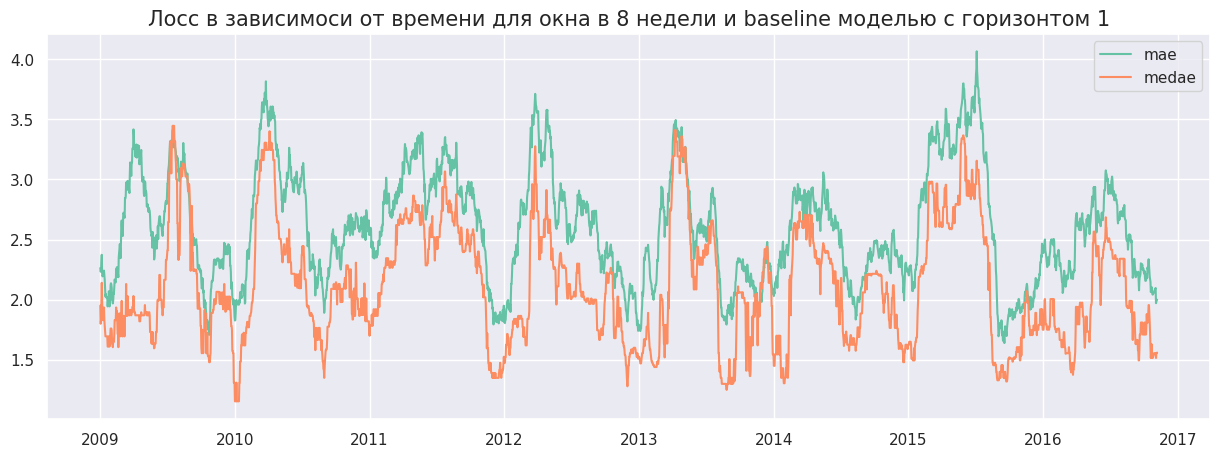

In [106]:
plt.figure(figsize=(15, 5))
plt.title('Лосс в зависимоси от времени для окна в 8 недели и baseline моделью с горизонтом 1', fontsize=15)
plt.plot(weather_df_daily_good['T (degC)'].index[:-28 * 2], mae, label='mae')
plt.plot(weather_df_daily_good['T (degC)'].index[:-28 * 2], medae, label='medae')
plt.legend()
plt.show()

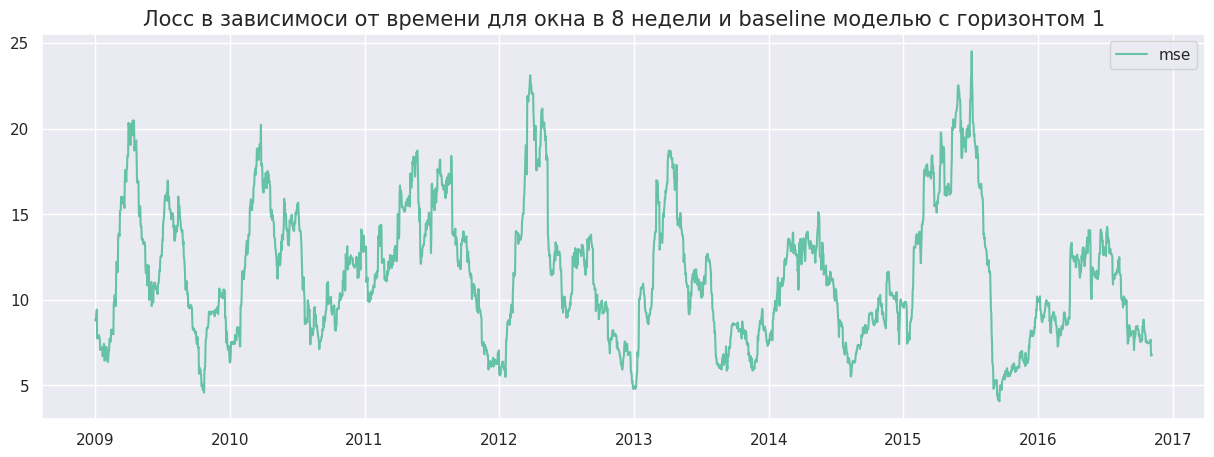

In [107]:
plt.figure(figsize=(15, 5))
plt.title('Лосс в зависимоси от времени для окна в 8 недели и baseline моделью с горизонтом 1', fontsize=15)
plt.plot(weather_df_daily_good['T (degC)'].index[:-28 * 2], mse, label='mse')
plt.legend()
plt.show()

In [108]:
mse, mae, smape, medae = window(preds2, 28)

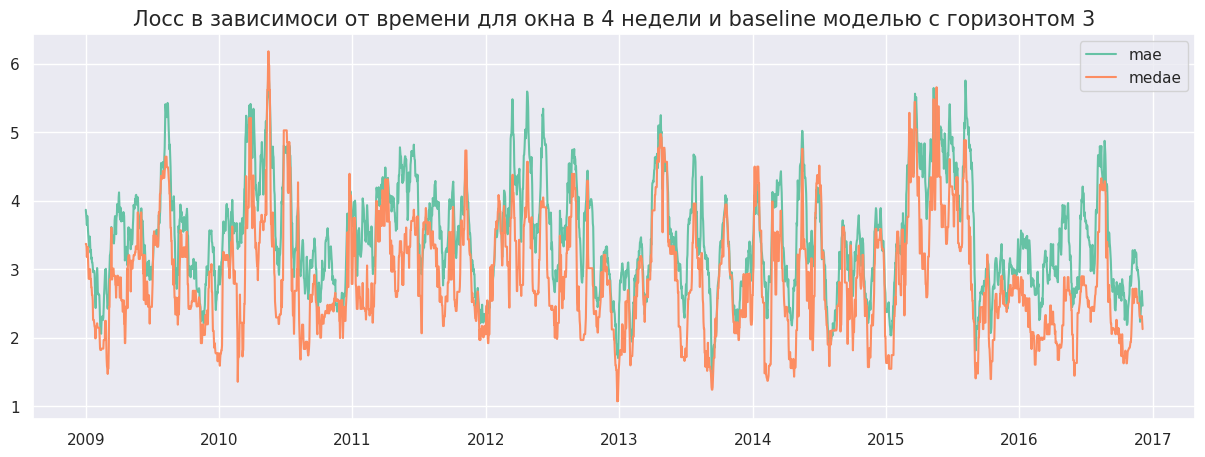

In [109]:
plt.figure(figsize=(15, 5))
plt.title('Лосс в зависимоси от времени для окна в 4 недели и baseline моделью с горизонтом 3', fontsize=15)
plt.plot(weather_df_daily_good['T (degC)'].index[:-28], mae, label='mae')
plt.plot(weather_df_daily_good['T (degC)'].index[:-28], medae, label='medae')
plt.legend()
plt.show()

**Выводы:** Чем больше горизонт прогнозирования, тем больше ошибка, так как присутствует ее накопление. Для SMAPE можно сказать, что есть некоторая годичная сезонность, для остальных же метрик нам либо везет и на протяжении пары недель похожая температура - тогда лосс пониже, либо происходит резкая смена температуры и лосс подскакивает

Валидация

In [41]:
from sklearn.model_selection import TimeSeriesSplit
ts_cv_1 = TimeSeriesSplit(n_splits=5, max_train_size=1000, test_size=8*7, gap=70)

Реализуем nested кросс-валидацию.

In [41]:
class CustomTimeSeriesSplit:

    def __init__(self,
                 train_set_size: int,
                 test_set_size: int
                 ):
        """
        :param train_set_size: data points (days) in each fold for the train set
        :param test_set_size: data points (days) in each fold for the test set
        """
        self.train_set_size = train_set_size
        self.test_set_size = test_set_size
        self._logger = logging.getLogger(__name__)

    def split(self,
              x: np.array,
              y: np.array = None):
        """Return train/test split indices.
        :param x: time series to use for prediction, shape (n_samples, n_features)
        :param y: time series to predict, shape (n_samples, n_features)
        :return: (train_indices, test_indices)
        Note: index of both x and y should be of type datetime.
        """
        if y is not None:
            assert x.index.equals(y.index)
        split_points = self.get_split_points(x)
        for split_point in split_points:
            is_train = (x.index < split_point) & (x.index >= split_point -
                                                  pd.Timedelta(self.train_set_size, unit='D'))
            is_test = (x.index >= split_point) & (x.index < split_point +
                                                  pd.Timedelta(self.test_set_size, unit='D'))
            if not is_train.any() or not is_test.any():
                self._logger.warning('Found %d train and %d test observations '
                                     'skipping fold for split point %s',
                                     is_train.sum(), is_test.sum(), split_point)
                continue
            dummy_ix = pd.Series(range(0, len(x)), index=x.index)
            ix_train = dummy_ix.loc[is_train].values
            ix_test = dummy_ix.loc[is_test].values
            if ix_train is None or ix_test is None:
                self._logger.warning('Found no data for train or test period, '
                                     'skipping fold for split date %s',
                                     split_point)
                continue
            yield ix_train, ix_test

    def get_split_points(self, x: np.array) -> pd.DatetimeIndex:
        """Get all possible split point dates"""
        start = x.index.min() + pd.Timedelta(self.train_set_size, unit='D')
        end = x.index.max() - pd.Timedelta(self.test_set_size - 1, unit='D')
        self._logger.info(f'Generating split points from {start} to {end}')
        split_range = pd.date_range(start, end, freq='D')
        first_split_point =  (len(split_range) + self.test_set_size - 1) % self.test_set_size
        return split_range[first_split_point::self.test_set_size]

Далее смотрим как это выглядит в стандартном случае (просто потом надо будет model заменить на другое)

In [43]:
outer_train_set_size = 7 * 16
outer_test_set_size = 7 * 8

outer_loop_splitter = CustomTimeSeriesSplit(
    train_set_size=outer_train_set_size,
    test_set_size=outer_test_set_size)

In [42]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

In [49]:
# The outer loop for algorithm selection and performance estimation
scores = []
for outer_train_idx, outer_test_idx in outer_loop_splitter.split(weather_df_daily_good.drop('target', axis = 1), weather_df_daily_good['target']):
    x_train = weather_df_daily_good.drop('target', axis = 1).iloc[outer_train_idx]
    y_train = weather_df_daily_good['target'].iloc[outer_train_idx]
    x_test = weather_df_daily_good.drop('target', axis = 1).iloc[outer_test_idx]
    y_test = weather_df_daily_good['target'].iloc[outer_test_idx]

    # Далее просто обучаем на трейне и предсказываем на тесте, считаем качество, например, это можно сделать так:
    model.fit(x_train, y_train)
    scores.append(mean_squared_error(y_test, model.predict(x_test)))
len(scores), np.array(scores).mean()

(413, 35.280349651014554)

## 4. Сведение к задаче регрессии

Вычислим простые признаки вида описательных статистик (сумма, максимум, минимум, стандартное отклонение) по нескольким размерам окон.

In [30]:
import statistics

# Функция для получения 4-х статистик: max, min, mean и std

def get_stats(df, window):
    maxx = []
    minn = []
    meann = []
    stdd = []
    for t in range(len(df) - window):
      minn.append(min(df[t:(t + window)]))
      maxx.append(max(df[t:(t + window)]))
      meann.append(np.array(df[t:(t + window)]).mean())
      stdd.append(statistics.stdev((df[t:(t + window)])))
    return maxx, minn, meann, stdd

Визуализируем для разных окон

window size: 5


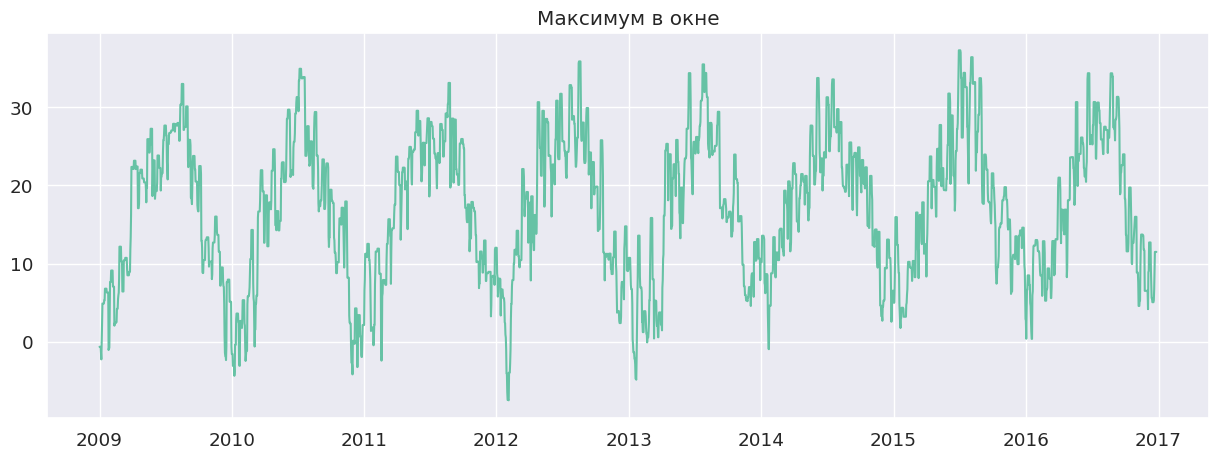

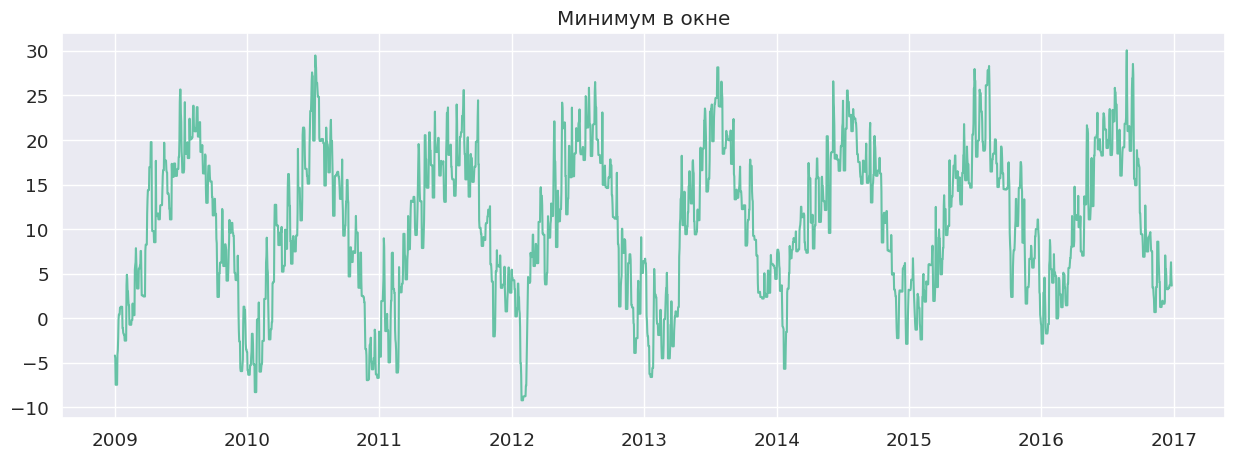

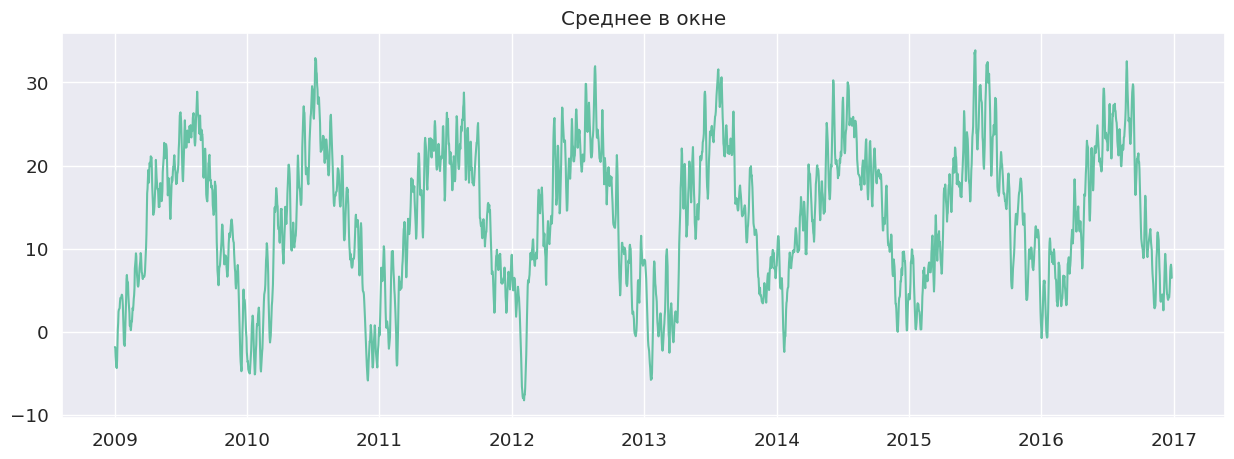

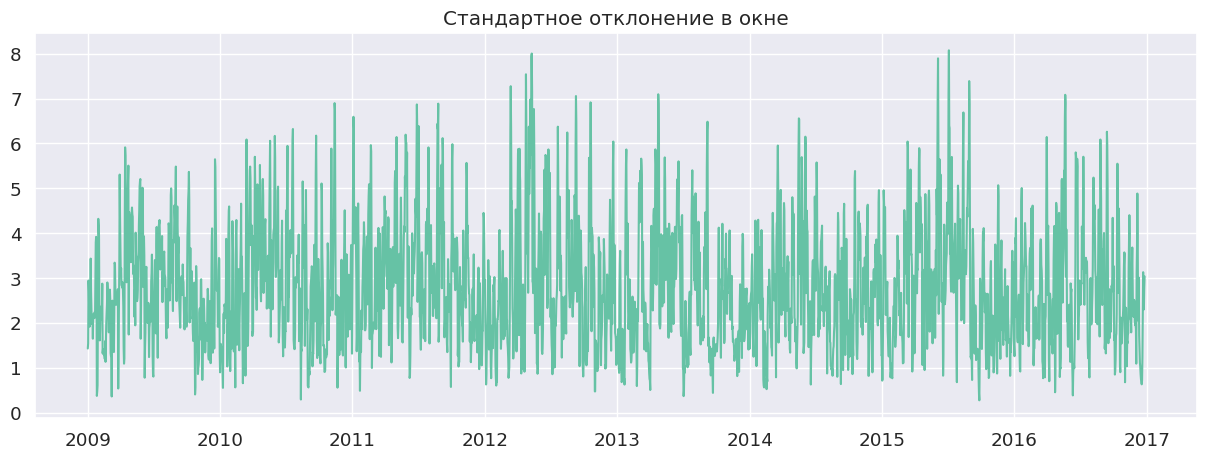

window size: 10


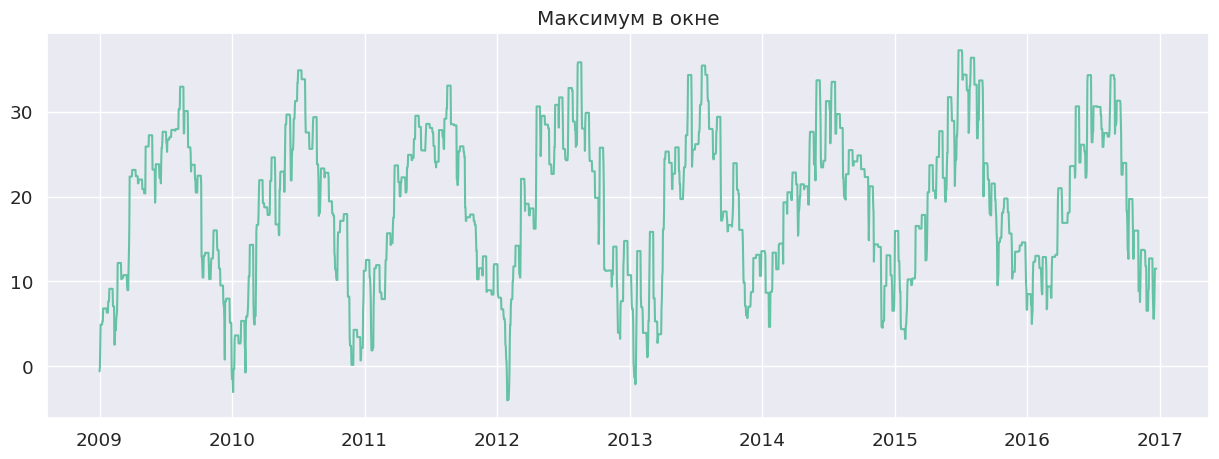

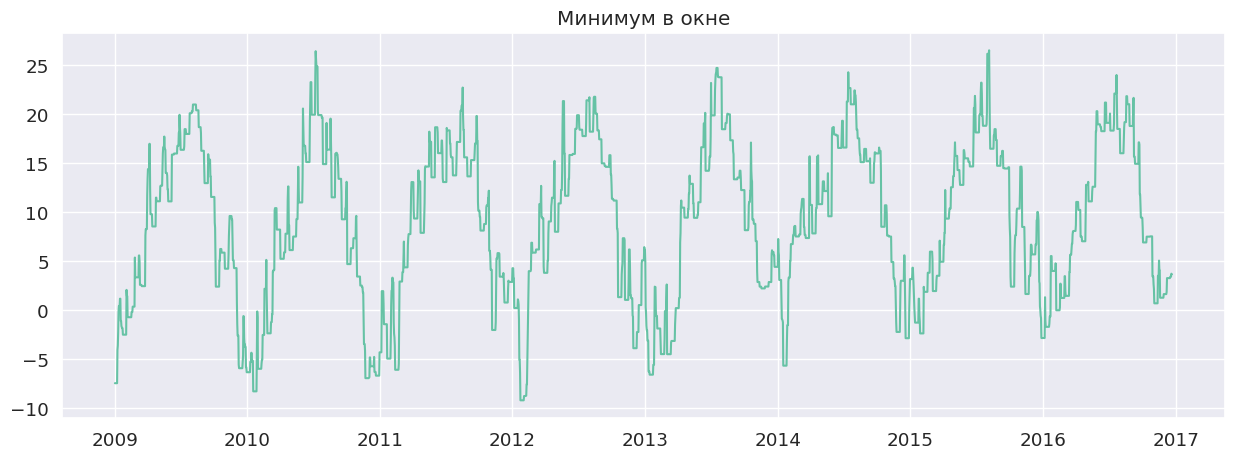

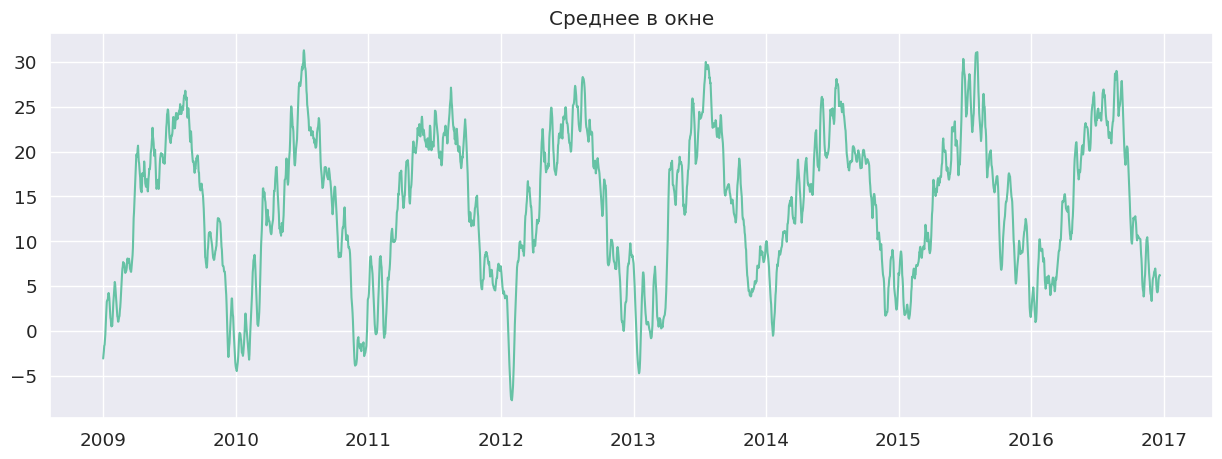

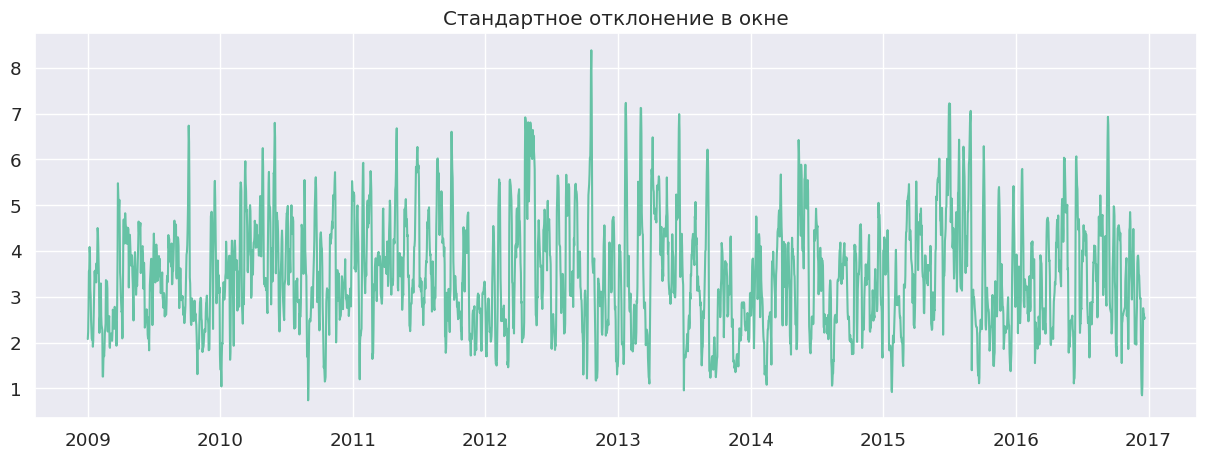

window size: 50


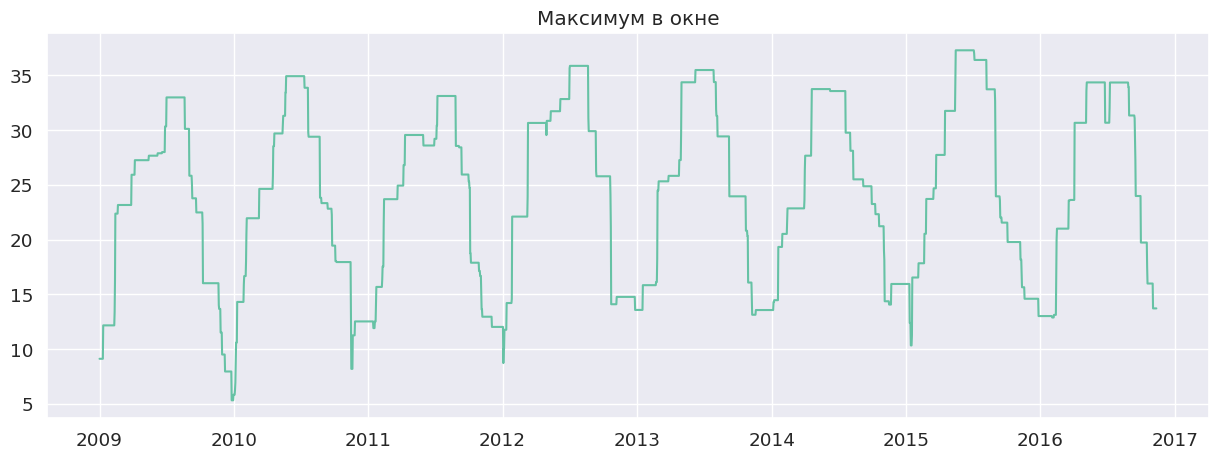

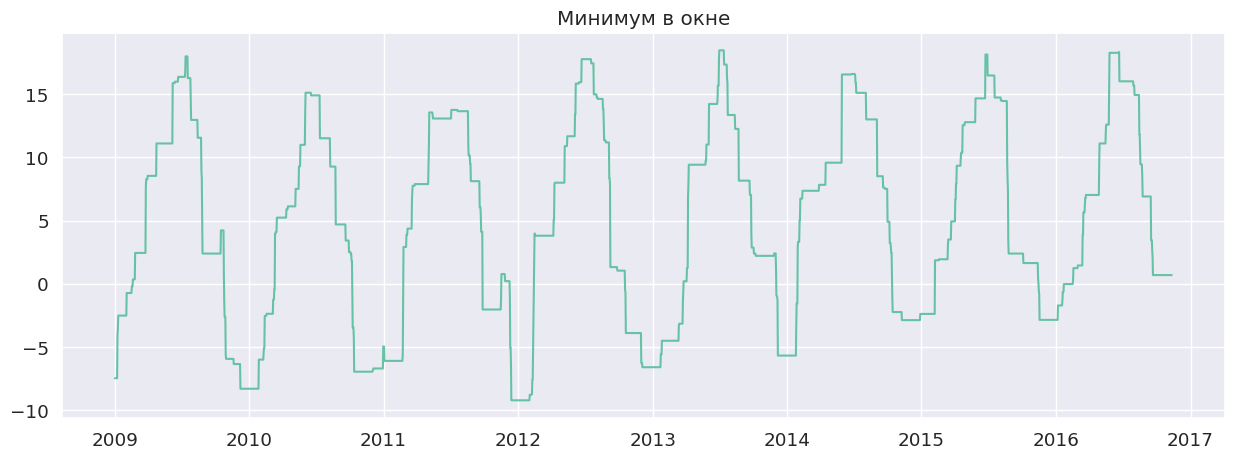

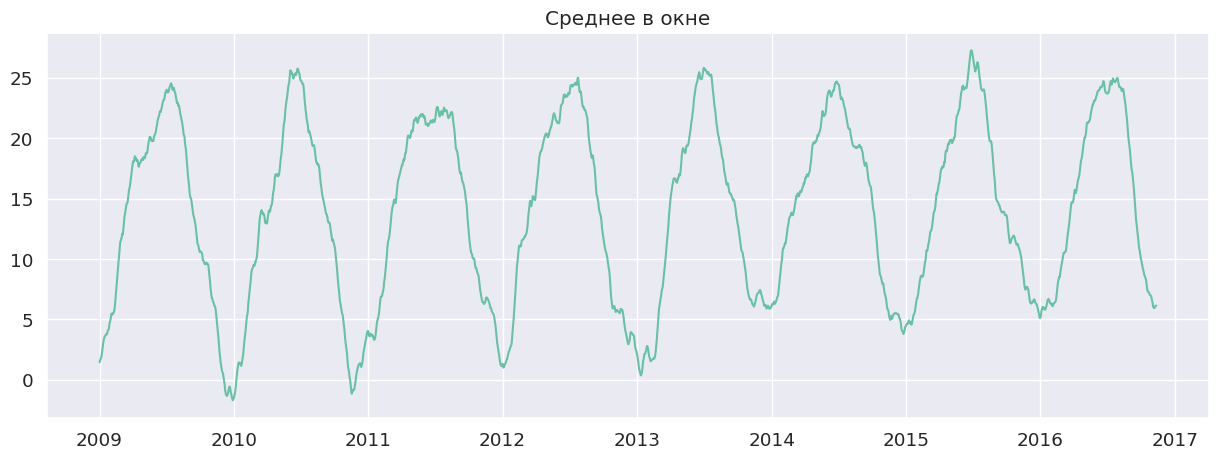

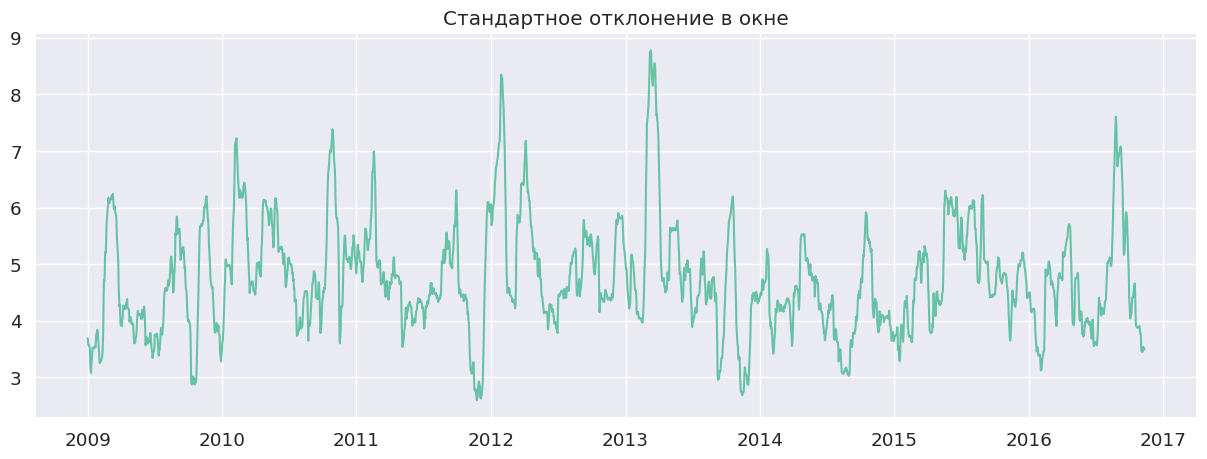

window size: 100


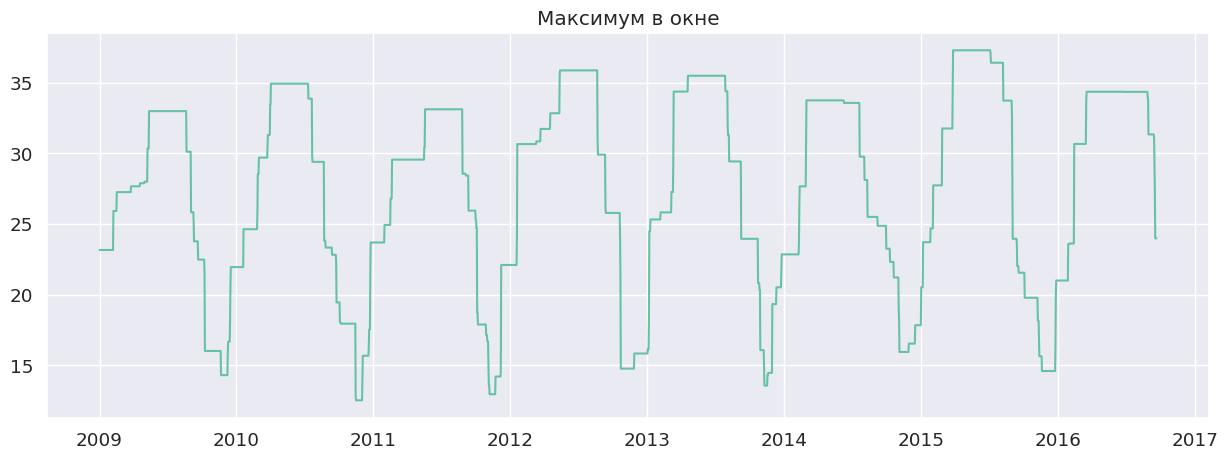

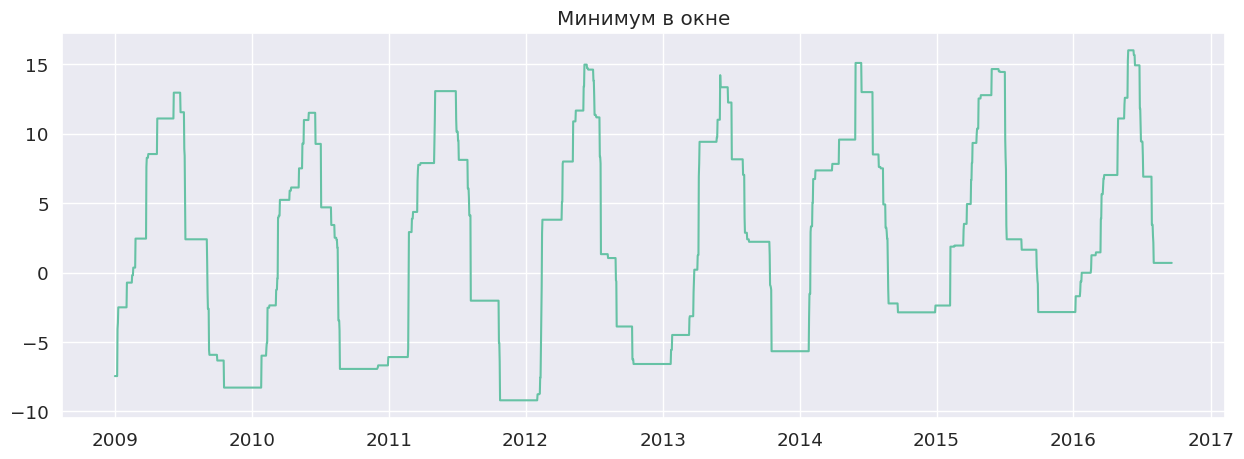

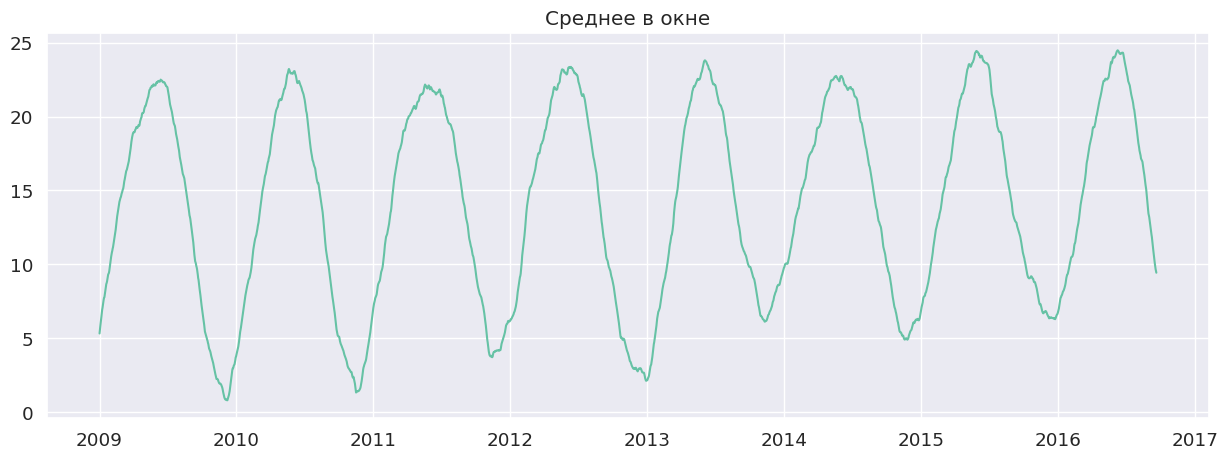

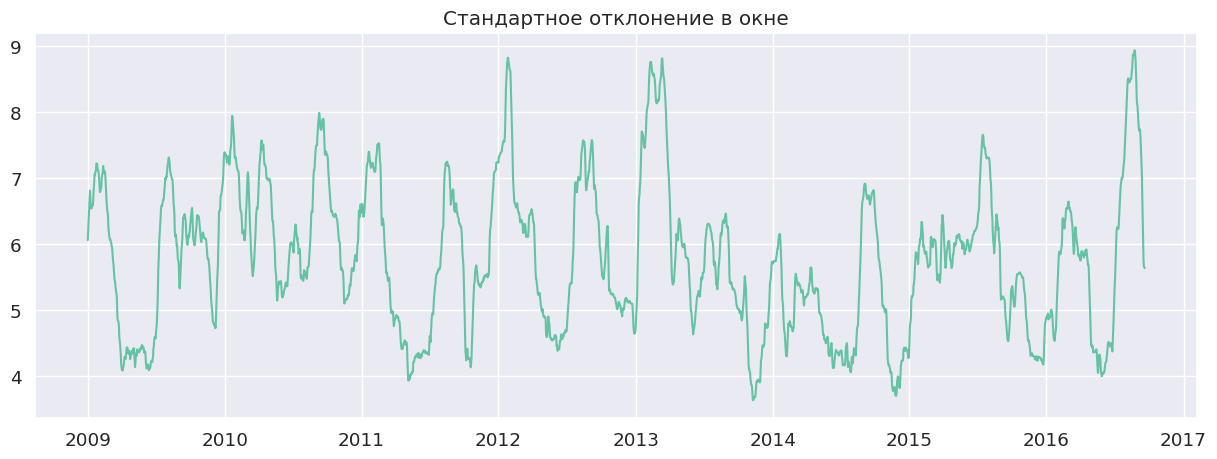

window size: 365


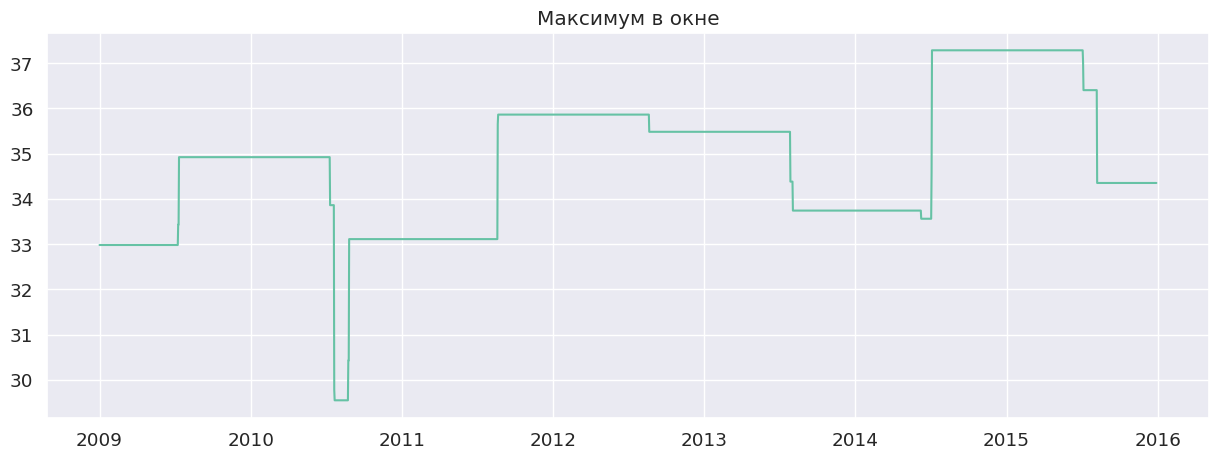

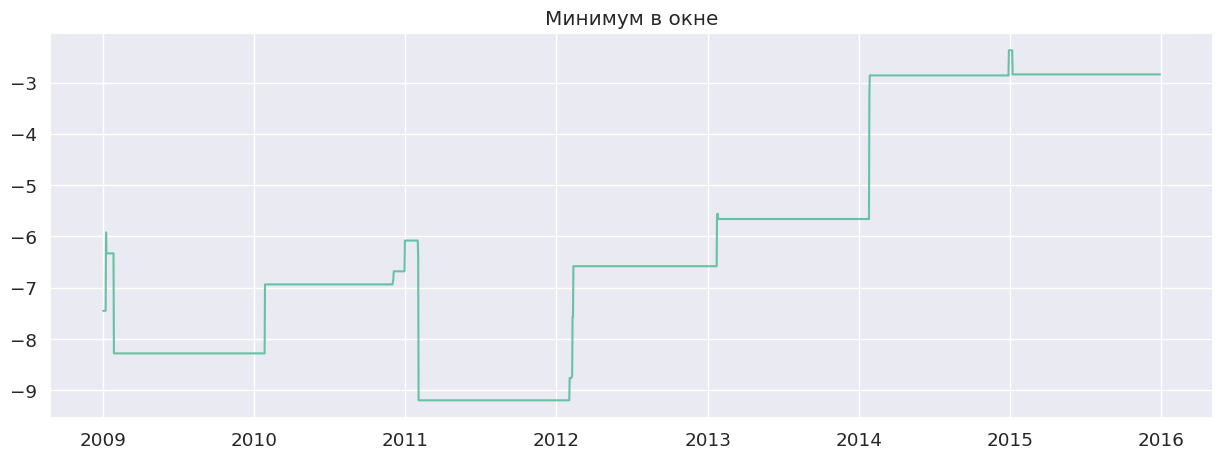

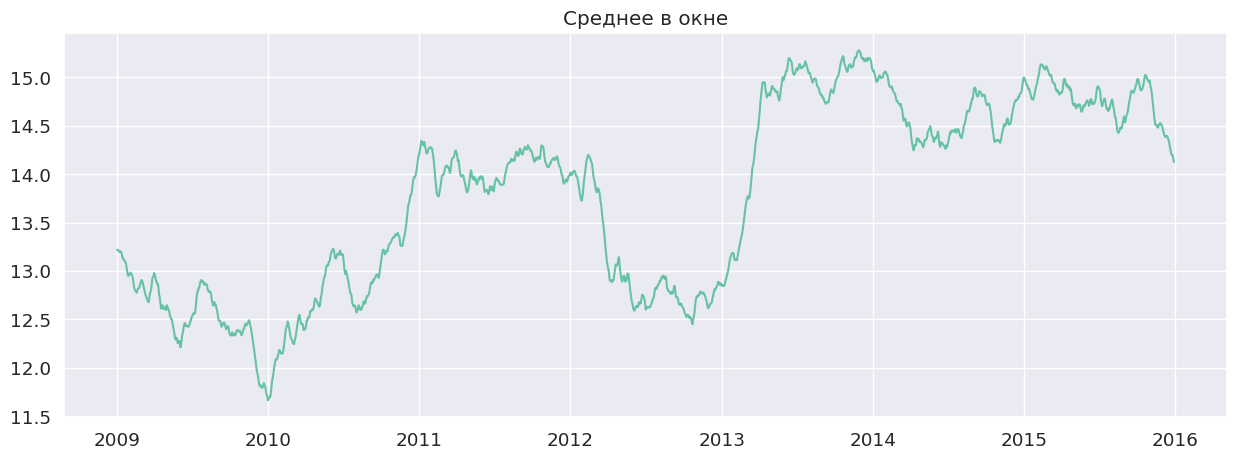

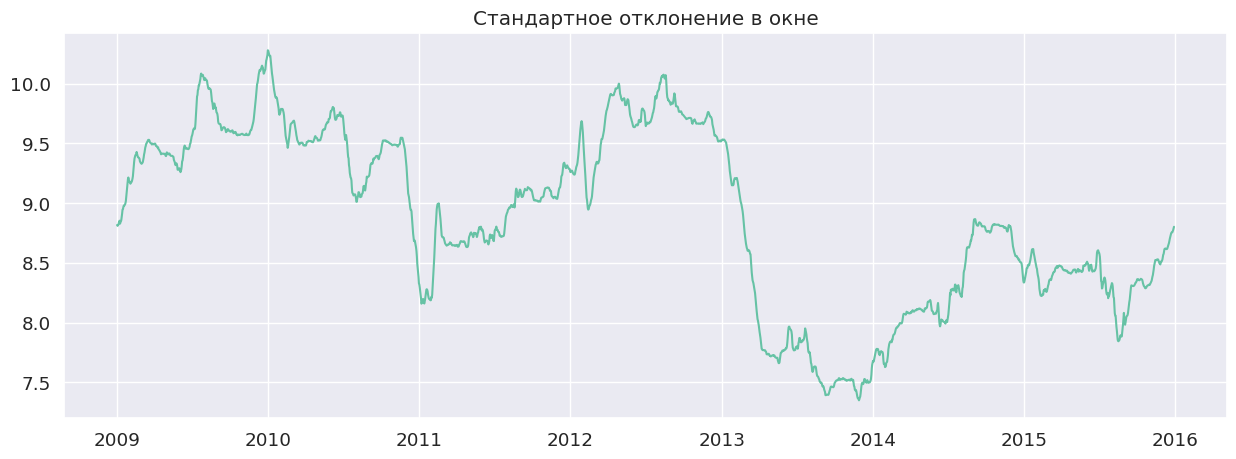

In [107]:
w = [5, 10, 50, 100, 365]
for i in w:
    maxx, minn, meann, stdd = get_stats(weather_df_daily_good['T (degC)'], i)
    print('window size:', i)
    plt.figure(figsize=(15, 5))
    plt.plot(weather_df_daily_good.index[:len(weather_df_daily_good) - i], maxx)
    plt.title('Максимум в окне')
    plt.show()

    plt.figure(figsize=(15, 5))
    plt.plot(weather_df_daily_good.index[:len(weather_df_daily_good) - i], minn)
    plt.title('Минимум в окне')
    plt.show()

    plt.figure(figsize=(15, 5))
    plt.plot(weather_df_daily_good.index[:len(weather_df_daily_good) - i], meann)
    plt.title('Среднее в окне')
    plt.show()

    plt.figure(figsize=(15, 5))
    plt.plot(weather_df_daily_good.index[:len(weather_df_daily_good) - i], stdd)
    plt.title('Стандартное отклонение в окне')
    plt.show()

Добавляем столбцы в датасет (окна в неделю и месяц)

In [31]:
w = [7, 30]
for i in w:
    maxx, minn, meann, stdd = get_stats(weather_df_daily_good['T (degC)'], i)
    # Добиваем средними до нужного размера:
    for k in range(i):
        maxx.append(np.array(maxx).mean())
        minn.append(np.array(minn).mean())
        meann.append(np.array(meann).mean())
        stdd.append(np.array(stdd).mean())

    name = 'T (degC)_max_window_' + str(i)
    weather_df_daily_good[name] = maxx
    name = 'T (degC)_min_window_' + str(i)
    weather_df_daily_good[name] = minn
    name = 'T (degC)_mean_window_' + str(i)
    weather_df_daily_good[name] = meann
    name = 'T (degC)_std_window_' + str(i)
    weather_df_daily_good[name] = stdd
weather_df_daily_good.head()

p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  VPmax (mbar)  \
Date                                                                          
2009-01-01   1000.87     -4.17    269.00        -5.36    94.8          4.48   
2009-01-02   1002.65     -2.12    271.12        -3.88    96.3          5.22   
2009-01-03   1002.49     -0.82    272.59        -6.09    93.9          5.75   
2009-01-04    992.93     -0.63    273.55        -2.26    93.9          5.83   
2009-01-05    997.54     -1.44    272.89        -2.45    93.2          5.49   

            VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  ...  \
Date                                                                ...   
2009-01-01          4.09          0.49       2.55             4.09  ...   
2009-01-02          4.58          0.70       2.86             4.59  ...   
2009-01-03          3.87          2.86       2.41             3.86  ...   
2009-01-04          5.17          1.53       3.27             5.25  ...   
2009-01-05          5.10          0.83       3.23             5.18  ...   

            wd (deg)  target  T (degC)_max_window_7  T (degC)_min_window_7  \
Date                                                                         
2009-01-01     357.9  -2.120                  -0.63                  -7.45   
2009-01-02     358.8  -0.820                  -0.63                  -7.45   
2009-01-03     357.2  -0.630                  -0.63                  -7.45   
2009-01-04     257.0  -1.440                  -0.63                  -7.45   
2009-01-05     358.9  -4.445                  -0.13                  -7.45   

            T (degC)_mean_window_7  T (degC)_std_window_7  \
Date                                                        
2009-01-01               -3.010714               2.477765   
2009-01-02               -2.995000               2.469523   
2009-01-03               -3.207857               2.445632   
2009-01-04               -3.410714               2.266919   
2009-01-05               -3.339286               2.374466   

            T (degC)_max_window_30  T (degC)_min_window_30  \
Date                                                         
2009-01-01                    6.80                   -7.45   
2009-01-02                    6.80                   -7.45   
2009-01-03                    6.80                   -7.45   
2009-01-04                    6.80                   -7.45   
2009-01-05                    7.64                   -7.45   

            T (degC)_mean_window_30  T (degC)_std_window_30  
Date                                                         
2009-01-01                 0.527833                3.726712  
2009-01-02                 0.640500                3.629617  
2009-01-03                 0.627833                3.640230  
2009-01-04                 0.778833                3.671918  
2009-01-05                 1.054500                3.867716  

[5 rows x 23 columns]

In [32]:
w = [7, 30]
for i in w:
    maxx, minn, meann, stdd = get_stats(weather_df_daily_good['p (mbar)'], i)
    # Добиваем средними до нужного размера:
    for k in range(i):
        maxx.append(np.array(maxx).mean())
        minn.append(np.array(minn).mean())
        meann.append(np.array(meann).mean())
        stdd.append(np.array(stdd).mean())

    name = 'p (mbar)_max_window_' + str(i)
    weather_df_daily_good[name] = maxx
    name = 'p (mbar)_min_window_' + str(i)
    weather_df_daily_good[name] = minn
    name = 'p (mbar)_mean_window_' + str(i)
    weather_df_daily_good[name] = meann
    name = 'p (mbar)_std_window_' + str(i)
    weather_df_daily_good[name] = stdd
weather_df_daily_good.head()

p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  VPmax (mbar)  \
Date                                                                          
2009-01-01   1000.87     -4.17    269.00        -5.36    94.8          4.48   
2009-01-02   1002.65     -2.12    271.12        -3.88    96.3          5.22   
2009-01-03   1002.49     -0.82    272.59        -6.09    93.9          5.75   
2009-01-04    992.93     -0.63    273.55        -2.26    93.9          5.83   
2009-01-05    997.54     -1.44    272.89        -2.45    93.2          5.49   

            VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  ...  \
Date                                                                ...   
2009-01-01          4.09          0.49       2.55             4.09  ...   
2009-01-02          4.58          0.70       2.86             4.59  ...   
2009-01-03          3.87          2.86       2.41             3.86  ...   
2009-01-04          5.17          1.53       3.27             5.25  ...   
2009-01-05          5.10          0.83       3.23             5.18  ...   

            T (degC)_mean_window_30  T (degC)_std_window_30  \
Date                                                          
2009-01-01                 0.527833                3.726712   
2009-01-02                 0.640500                3.629617   
2009-01-03                 0.627833                3.640230   
2009-01-04                 0.778833                3.671918   
2009-01-05                 1.054500                3.867716   

            p (mbar)_max_window_7  p (mbar)_min_window_7  \
Date                                                       
2009-01-01                1002.65                 992.93   
2009-01-02                1004.61                 992.93   
2009-01-03                1004.61                 992.93   
2009-01-04                1004.61                 992.93   
2009-01-05                1005.71                 997.54   

            p (mbar)_mean_window_7  p (mbar)_std_window_7  \
Date                                                        
2009-01-01              999.054286               3.380423   
2009-01-02              999.588571               3.960944   
2009-01-03              999.762857               4.140856   
2009-01-04              999.977143               4.339550   
2009-01-05             1001.802857               3.484751   

            p (mbar)_max_window_30  p (mbar)_min_window_30  \
Date                                                         
2009-01-01                 1005.71                  970.98   
2009-01-02                 1005.71                  970.98   
2009-01-03                 1005.71                  970.98   
2009-01-04                 1005.71                  970.98   
2009-01-05                 1005.71                  970.98   

            p (mbar)_mean_window_30  p (mbar)_std_window_30  
Date                                                         
2009-01-01               992.887333               10.438431  
2009-01-02               992.772333               10.366208  
2009-01-03               992.346000               10.207757  
2009-01-04               991.689333               10.166257  
2009-01-05               991.136667               10.540273  

[5 rows x 31 columns]

Обучим градиентый бустинг и обычный многослойный перцептрон с использованием написанного скользящего контроля. Посчитаем качество.

In [55]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 14.6 MB/s eta 0:00:00


In [56]:
from catboost import CatBoostRegressor

In [57]:
X_train, Y_train = weather_df_daily_good[:-365].drop(labels=['target'], axis=1), target[:-365]
X_test, Y_test = weather_df_daily_good[-365:].drop(labels=['target'], axis=1), target[-365:]

In [58]:
cat = CatBoostRegressor()
cat.fit(X_train, Y_train)
predicted = cat.predict(X_test)

Learning rate set to 0.047481
0:	learn: 8.6809517	total: 57.4ms	remaining: 57.3s
1:	learn: 8.3561631	total: 66.4ms	remaining: 33.1s
2:	learn: 8.0428563	total: 75ms	remaining: 24.9s
3:	learn: 7.7572905	total: 83ms	remaining: 20.7s
4:	learn: 7.4687135	total: 91ms	remaining: 18.1s
5:	learn: 7.2034230	total: 99.3ms	remaining: 16.4s
6:	learn: 6.9497002	total: 107ms	remaining: 15.2s
7:	learn: 6.7101786	total: 115ms	remaining: 14.3s
8:	learn: 6.4883175	total: 123ms	remaining: 13.6s
9:	learn: 6.2680923	total: 132ms	remaining: 13s
10:	learn: 6.0669489	total: 146ms	remaining: 13.2s
11:	learn: 5.8811752	total: 158ms	remaining: 13s
12:	learn: 5.7046133	total: 174ms	remaining: 13.2s
13:	learn: 5.5302765	total: 183ms	remaining: 12.9s
14:	learn: 5.3671880	total: 194ms	remaining: 12.8s
15:	learn: 5.2026459	total: 214ms	remaining: 13.2s
16:	learn: 5.0494239	total: 223ms	remaining: 12.9s
17:	learn: 4.9227642	total: 231ms	remaining: 12.6s
18:	learn: 4.7814156	total: 239ms	remaining: 12.4s
19:	learn: 4.65

In [59]:
add_results_in_comparison_table('catboost', Y_test, predicted)

method        MSE       MAE      SMAPE     MedAE
0  baseline_horizon_1  11.368181  2.583306  30.244208  2.070000
1  baseline_horizon_2  16.734771  3.136148  35.871218  2.440000
2  baseline_horizon_3  19.968890  3.467079  39.257602  2.740000
3            catboost   7.066861  2.010571  24.684209  1.628357

Чтож, catboost уже побил baseline, он молодец, перейдем к обычному многослойному перцептрону

In [36]:
import time
from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as sps
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.preprocessing import MinMaxScaler

import torch
from torch import nn
from torch.utils.data import Dataset, TensorDataset, DataLoader, RandomSampler, SequentialSampler

from IPython.display import clear_output
%matplotlib inline

In [52]:
device = f'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [53]:
class MyDataset(torch.utils.data.Dataset):
    """
    Обернем наш датасет в такой класс для удобства
    """
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return [torch.tensor(self.x[idx, :], dtype=torch.double), self.y[idx]]

In [54]:
from sklearn.preprocessing import StandardScaler

x_scale = StandardScaler()
y_scale = StandardScaler()
X_train_scaled = x_scale.fit_transform(X_train)
y_train_scaled = y_scale.fit_transform(np.array(Y_train).reshape(-1, 1))
X_test_scaled = x_scale.transform(X_test)
y_test_scaled = y_scale.transform(np.array(Y_test).reshape(-1, 1))

In [55]:
train_set = MyDataset(X_train_scaled, y_train_scaled)
train_loader = torch.utils.data.DataLoader(train_set, 64, shuffle=False)

test_set = MyDataset(X_test_scaled, y_test_scaled)
test_loader = torch.utils.data.DataLoader(test_set, 64, shuffle=False)

model0 = nn.Sequential(
    nn.Linear(X_train.shape[1], 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 1)
)
optimizer0 = torch.optim.Adam(model0.parameters(), lr = 0.0001)
criterion0 = nn.MSELoss()

In [56]:
from tqdm import trange

In [57]:
def train(model, optimizer, criterion, train_loader, test_loader):
    '''
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
    '''
    test_overall = [] # лосс на тесте на каждой эпохе (то есть тут будет epochs значений)
    train_overall = [] # лосс на трейне на каждой эпохе
    for epoch in trange(50): # Ну путь будет столько эпох
        model.train()
        train_RMSE = [] # тут будут лоссы по батчам трейна (обновляется каждую эпоху)
        for batch in train_loader:
            x_train = batch[0]                              # Извлекаем данные и таргет из MyDataset (у нас же на нулевом месте
            y_train = batch[1]                              # в списке данные, а на первом - таргет)
            y_pred = model(x_train.float())         # Делаем предсказания
            loss = criterion(y_pred, y_train.float())        # Считаем лосс
            loss.backward()                                # Считаем градиенты
            optimizer.step()                               # Делаем шаг градиентного спуска
            optimizer.zero_grad()                          # Обнуляем градиенты
            with torch.no_grad():
                l = torch.mean((y_pred * y_scale.scale_ - (y_train.float() * y_scale.scale_)) ** 2) # Вот тут мы считаем лосс, приводя
                # таргет обратно к нормально виду
                train_RMSE.append(np.sqrt(l.numpy()))
                
        train_overall.append(np.mean(train_RMSE)) # аппендим средний лосс по всем батчам на этой эпохе
        
        # Сразу же будем отслеживать лосс на тесте
        test_RMSE = [] # тут будут лоссы по батчам теста (обновляется каждую эпоху)
        model.eval()
        with torch.no_grad():
            for batch in test_loader:
                x_test = batch[0]
                y_test = batch[1]
                y_pred = model(x_test.float())
                loss = criterion((y_pred * y_scale.scale_), (y_test * y_scale.scale_).float()) # Вот тут мы считаем лосс, приводя
                # таргет обратно к нормально виду
                test_RMSE.append(np.sqrt(loss.numpy()))
        test_overall.append(np.mean(test_RMSE)) # аппендим средний лосс по всем батчам на этой эпохе
    return train_overall, test_overall # будем возвращать лоссы на тесте и трейне по эпохам, чтобы потом визуализировать 

In [58]:
train_overall, test_overall = train(model0, optimizer0, criterion0, train_loader, test_loader)

100%|██████████| 50/50 [00:26<00:00,  1.86it/s]


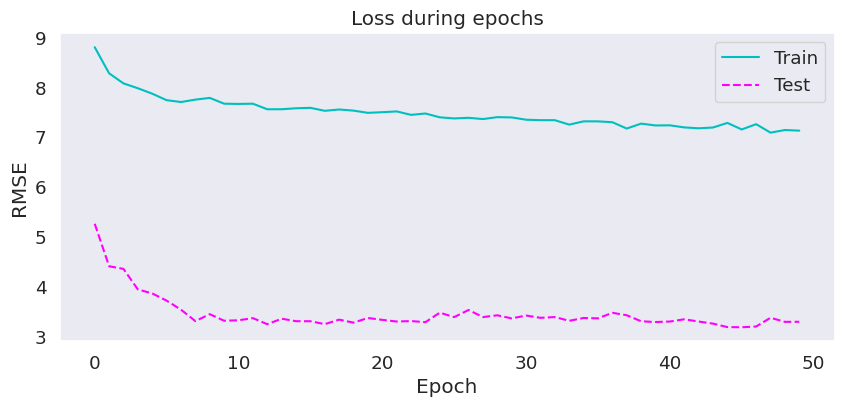

In [59]:
x = np.arange(0, 50)
plt.figure(figsize=(10, 4))
plt.plot(x, train_overall, 'c', linestyle = '-')
plt.plot(x, test_overall, 'magenta', linestyle = '--')
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.title("Loss during epochs")
plt.legend(['Train', 'Test'])
plt.grid()
plt.show()

In [60]:
DL_preds = model0(torch.tensor(X_test_scaled).float()).detach().numpy() * y_scale.scale_ + y_scale.mean_

In [61]:
add_results_in_comparison_table('NNLinear', Y_test, DL_preds.reshape(1,-1)[0])

method        MSE       MAE      SMAPE     MedAE
0  baseline_horizon_1  11.368181  2.583306  30.244208  2.070000
1  baseline_horizon_2  16.734771  3.136148  35.871218  2.440000
2  baseline_horizon_3  19.968890  3.467079  39.257602  2.740000
3            catboost   7.278445  2.029239  24.393827  1.676472
4            NNLinear  10.802511  2.577498  34.265846  2.197401

Ну так себе, если честно. Градиентный бустинг лучше справился

Визуализируем полученные прогнозы на графике, сравнив их с истинными значениями ряда

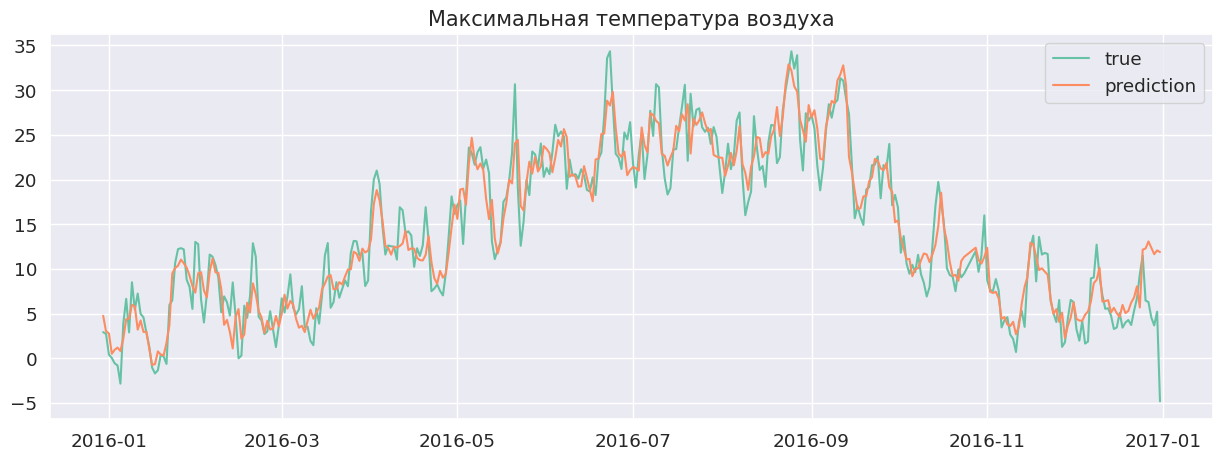

In [59]:
# Предсказания catboost

plot_results(Y_test, predicted, plot_conf_int=False)

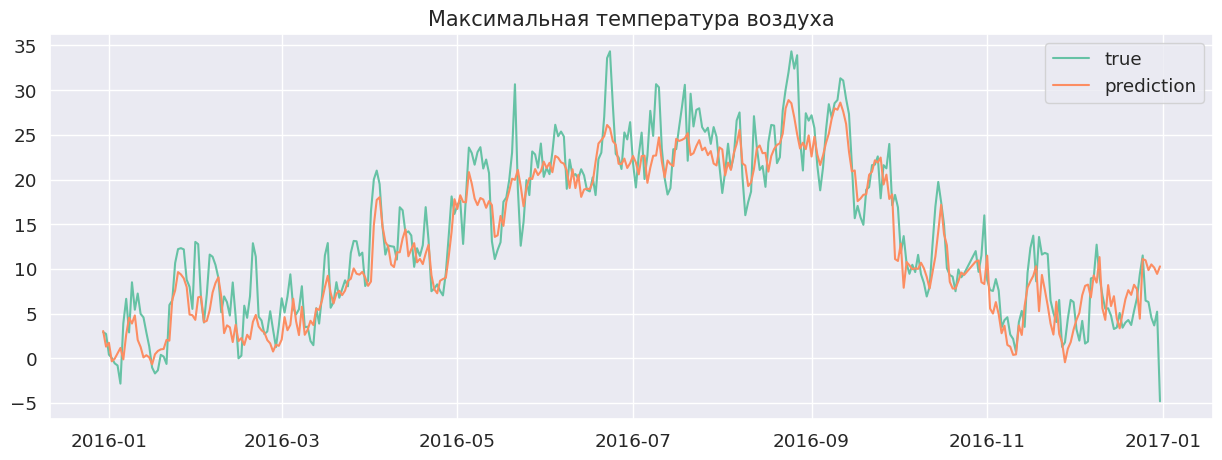

In [62]:
# Предсказания перцептрона

plot_results(Y_test, DL_preds, plot_conf_int=False)

Градиентный бустинг предсказывает хорошо, а вот многослойный перцептрон так себе, он слабо улавливает какие-то резкие пики, однако годовую сезонность он уловил

Не стал строить графики для всех данных, так как на них ничерта не видно, например, вот:

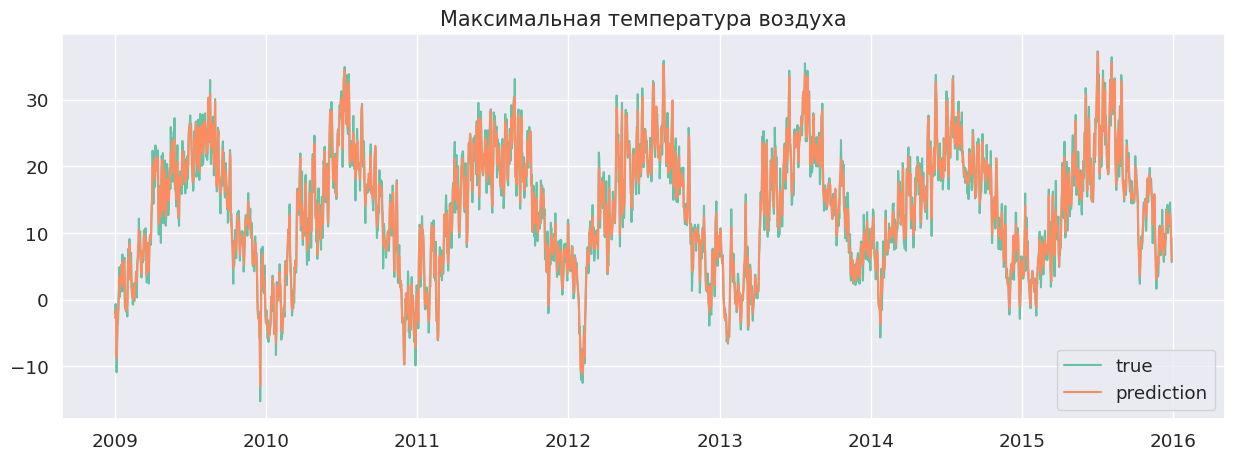

In [108]:
# Это catboost на трейне

plot_results(Y_train, cat.predict(X_train), plot_conf_int=False)

Ну, точнее видно, что модель справляется хорошо, но насколько хорошо не ясно (для бейзлайна графики тоже выглядят похожим образом, однако нас такой результат не устраивает, мы как раз хотим его побить)

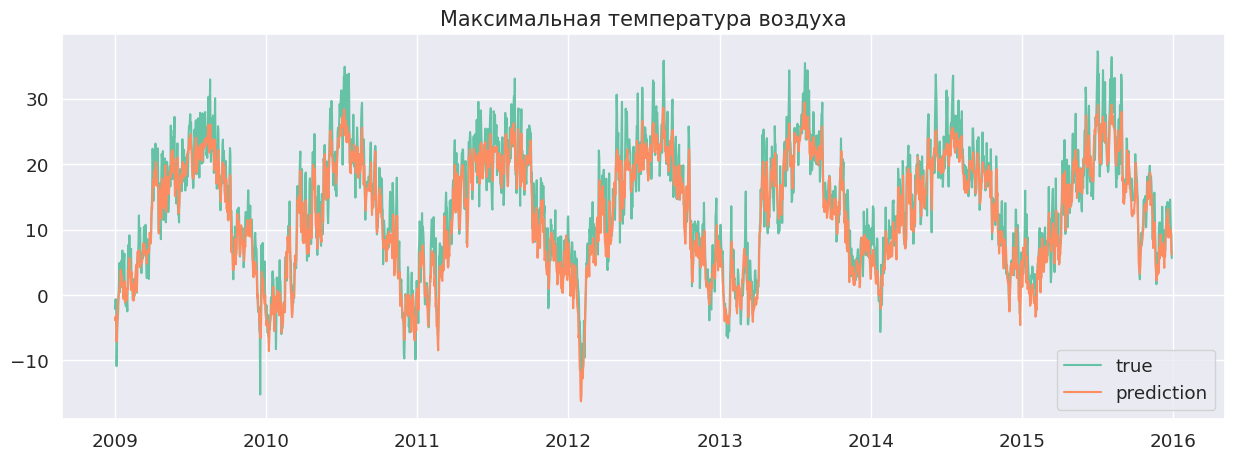

In [63]:
# А это NNLinear на трейне

plot_results(Y_train, model0(torch.tensor(X_train_scaled).float()).detach().numpy() * y_scale.scale_ + y_scale.mean_, plot_conf_int=False)

Ну ладно, для перцептрона на трейне тоже видно, что он пики слабо улавлиает, то есть он больше усредняет, но в целом он неплох

Библиотека <a href="https://tsfresh.com/">tsfresh</a> для генерации большого количества признаков

In [33]:
!pip install tsfresh

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:
from tsfresh.feature_extraction import extract_features
from tsfresh.utilities.dataframe_functions import roll_time_series

In [35]:
weather_df_daily_good['id'] = np.array(list(range(365)) * 7 + list(range(364))) # Сделаем так, чтобы для каждого дня в году был свой id, то есть у первого января каждого года
                                                                                # будет одинаковый id (так как это по сути одни и те же сущности)
weather_df_daily_good['time'] = weather_df_daily_good.index
weather_df_daily_good.head()

p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  VPmax (mbar)  \
Date                                                                          
2009-01-01   1000.87     -4.17    269.00        -5.36    94.8          4.48   
2009-01-02   1002.65     -2.12    271.12        -3.88    96.3          5.22   
2009-01-03   1002.49     -0.82    272.59        -6.09    93.9          5.75   
2009-01-04    992.93     -0.63    273.55        -2.26    93.9          5.83   
2009-01-05    997.54     -1.44    272.89        -2.45    93.2          5.49   

            VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  ...  \
Date                                                                ...   
2009-01-01          4.09          0.49       2.55             4.09  ...   
2009-01-02          4.58          0.70       2.86             4.59  ...   
2009-01-03          3.87          2.86       2.41             3.86  ...   
2009-01-04          5.17          1.53       3.27             5.25  ...   
2009-01-05          5.10          0.83       3.23             5.18  ...   

            p (mbar)_max_window_7  p (mbar)_min_window_7  \
Date                                                       
2009-01-01                1002.65                 992.93   
2009-01-02                1004.61                 992.93   
2009-01-03                1004.61                 992.93   
2009-01-04                1004.61                 992.93   
2009-01-05                1005.71                 997.54   

            p (mbar)_mean_window_7  p (mbar)_std_window_7  \
Date                                                        
2009-01-01              999.054286               3.380423   
2009-01-02              999.588571               3.960944   
2009-01-03              999.762857               4.140856   
2009-01-04              999.977143               4.339550   
2009-01-05             1001.802857               3.484751   

            p (mbar)_max_window_30  p (mbar)_min_window_30  \
Date                                                         
2009-01-01                 1005.71                  970.98   
2009-01-02                 1005.71                  970.98   
2009-01-03                 1005.71                  970.98   
2009-01-04                 1005.71                  970.98   
2009-01-05                 1005.71                  970.98   

            p (mbar)_mean_window_30  p (mbar)_std_window_30  id       time  
Date                                                                        
2009-01-01               992.887333               10.438431   0 2009-01-01  
2009-01-02               992.772333               10.366208   1 2009-01-02  
2009-01-03               992.346000               10.207757   2 2009-01-03  
2009-01-04               991.689333               10.166257   3 2009-01-04  
2009-01-05               991.136667               10.540273   4 2009-01-05  

[5 rows x 33 columns]

На всех данных у меня упал extract_features (закончилась память на ОЗУ, поэтому пробуем запустить на части)

In [38]:
df = weather_df_daily_good[:730]

In [40]:
df_rolled = roll_time_series(df, column_id="id", column_sort="time")

Rolling:  50%|█████     | 1/2 [00:00<00:00,  1.94it/s]/usr/local/lib/python3.9/dist-packages/tsfresh/utilities/dataframe_functions.py:350: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  return [grouped_data.apply(_f)]
Rolling: 100%|██████████| 2/2 [00:00<00:00,  2.38it/s]


In [41]:
len(df_rolled)

1095

In [42]:
df_rolled.head()

p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  VPmax (mbar)  \
0     1000.87     -4.17    269.00        -5.36    94.8          4.48   
365   1000.87     -4.17    269.00        -5.36    94.8          4.48   
730    975.72     -2.84    272.89        -3.41    97.4          4.95   
1     1002.65     -2.12    271.12        -3.88    96.3          5.22   
366   1002.65     -2.12    271.12        -3.88    96.3          5.22   

     VPact (mbar)  VPdef (mbar)  sh (g/kg)  H2OC (mmol/mol)  ...  \
0            4.09          0.49       2.55             4.09  ...   
365          4.09          0.49       2.55             4.09  ...   
730          4.75          0.34       3.06             4.91  ...   
1            4.58          0.70       2.86             4.59  ...   
366          4.58          0.70       2.86             4.59  ...   

     p (mbar)_max_window_7  p (mbar)_min_window_7  p (mbar)_mean_window_7  \
0                  1002.65                 992.93              999.054286   
365                1002.65                 992.93              999.054286   
730                 992.69                 975.72              986.544286   
1                  1004.61                 992.93              999.588571   
366                1004.61                 992.93              999.588571   

     p (mbar)_std_window_7  p (mbar)_max_window_30  p (mbar)_min_window_30  \
0                 3.380423                 1005.71                  970.98   
365               3.380423                 1005.71                  970.98   
730               6.906605                 1012.47                  970.31   
1                 3.960944                 1005.71                  970.98   
366               3.960944                 1005.71                  970.98   

     p (mbar)_mean_window_30  p (mbar)_std_window_30  \
0                 992.887333               10.438431   
365               992.887333               10.438431   
730               992.209667               10.343813   
1                 992.772333               10.366208   
366               992.772333               10.366208   

                           id       time  
0    (0, 2009-01-01 00:00:00) 2009-01-01  
365  (0, 2010-01-01 00:00:00) 2009-01-01  
730  (0, 2010-01-01 00:00:00) 2010-01-01  
1    (1, 2009-01-02 00:00:00) 2009-01-02  
366  (1, 2010-01-02 00:00:00) 2009-01-02  

[5 rows x 33 columns]

In [43]:
df_features = extract_features(df_rolled, column_id="id", column_sort="time")

Feature Extraction: 100%|██████████| 22630/22630 [13:56<00:00, 27.06it/s]


In [44]:
df_features.head()

p (mbar)__variance_larger_than_standard_deviation  \
0 2009-01-01                                                0.0   
  2010-01-01                                                1.0   
1 2009-01-02                                                0.0   
  2010-01-02                                                1.0   
2 2009-01-03                                                0.0   

              p (mbar)__has_duplicate_max  p (mbar)__has_duplicate_min  \
0 2009-01-01                          0.0                          0.0   
  2010-01-01                          0.0                          0.0   
1 2009-01-02                          0.0                          0.0   
  2010-01-02                          0.0                          0.0   
2 2009-01-03                          0.0                          0.0   

              p (mbar)__has_duplicate  p (mbar)__sum_values  \
0 2009-01-01                      0.0               1000.87   
  2010-01-01                      0.0               1976.59   
1 2009-01-02                      0.0               1002.65   
  2010-01-02                      0.0               1994.47   
2 2009-01-03                      0.0               1002.49   

              p (mbar)__abs_energy  p (mbar)__mean_abs_change  \
0 2009-01-01          1.001741e+06                        NaN   
  2010-01-01          1.953770e+06                      25.15   
1 2009-01-02          1.005307e+06                        NaN   
  2010-01-02          1.989014e+06                      10.83   
2 2009-01-03          1.004986e+06                        NaN   

              p (mbar)__mean_change  p (mbar)__mean_second_derivative_central  \
0 2009-01-01                    NaN                                       NaN   
  2010-01-01                 -25.15                                       NaN   
1 2009-01-02                    NaN                                       NaN   
  2010-01-02                 -10.83                                       NaN   
2 2009-01-03                    NaN                                       NaN   

              p (mbar)__median  ...  \
0 2009-01-01          1000.870  ...   
  2010-01-01           988.295  ...   
1 2009-01-02          1002.650  ...   
  2010-01-02           997.235  ...   
2 2009-01-03          1002.490  ...   

              p (mbar)_std_window_30__fourier_entropy__bins_5  \
0 2009-01-01                                              NaN   
  2010-01-01                                             -0.0   
1 2009-01-02                                              NaN   
  2010-01-02                                             -0.0   
2 2009-01-03                                              NaN   

              p (mbar)_std_window_30__fourier_entropy__bins_10  \
0 2009-01-01                                               NaN   
  2010-01-01                                              -0.0   
1 2009-01-02                                               NaN   
  2010-01-02                                              -0.0   
2 2009-01-03                                               NaN   

              p (mbar)_std_window_30__fourier_entropy__bins_100  \
0 2009-01-01                                                NaN   
  2010-01-01                                               -0.0   
1 2009-01-02                                                NaN   
  2010-01-02                                               -0.0   
2 2009-01-03                                                NaN   

              p (mbar)_std_window_30__permutation_entropy__dimension_3__tau_1  \
0 2009-01-01                                                NaN                 
  2010-01-01                                                NaN                 
1 2009-01-02                                                NaN                 
  2010-01-02                                                NaN                 
2 2009-01-03                                                NaN               

In [45]:
df_features.shape

(730, 24273)

24273 новых признаков получили, надо уменьшать их количество с помощью PSA/UMAP/TSNE

In [65]:
from sklearn.decomposition import PCA

In [67]:
from sklearn.impute import SimpleImputer

df_features = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(df_features)

In [68]:
X_transformed = PCA(n_components=30).fit_transform(df_features)

In [69]:
X_transformed.shape

(730, 30)

Обучим модель, посчитаем ее качество и построим график прогноза.

In [77]:
final = pd.concat((df, pd.DataFrame(X_transformed).set_index(df.index)), axis = 1)

In [81]:
cat = CatBoostRegressor()
cat.fit(final.drop('target', axis=1)[:530], final['target'][:530])
predict = cat.predict(final.drop('target', axis=1)[530:])

Learning rate set to 0.037035
0:	learn: 8.8931001	total: 18.5ms	remaining: 18.5s
1:	learn: 8.6444668	total: 32.4ms	remaining: 16.1s
2:	learn: 8.4010824	total: 45.8ms	remaining: 15.2s
3:	learn: 8.1777211	total: 59.2ms	remaining: 14.7s
4:	learn: 7.9660446	total: 72.7ms	remaining: 14.5s
5:	learn: 7.7665656	total: 86ms	remaining: 14.2s
6:	learn: 7.5691922	total: 102ms	remaining: 14.5s
7:	learn: 7.3816938	total: 115ms	remaining: 14.3s
8:	learn: 7.1780487	total: 129ms	remaining: 14.2s
9:	learn: 7.0171315	total: 145ms	remaining: 14.4s
10:	learn: 6.8392101	total: 161ms	remaining: 14.5s
11:	learn: 6.6744266	total: 175ms	remaining: 14.4s
12:	learn: 6.5220364	total: 189ms	remaining: 14.3s
13:	learn: 6.3533130	total: 206ms	remaining: 14.5s
14:	learn: 6.2002785	total: 220ms	remaining: 14.5s
15:	learn: 6.0595133	total: 234ms	remaining: 14.4s
16:	learn: 5.9145731	total: 248ms	remaining: 14.3s
17:	learn: 5.7806758	total: 262ms	remaining: 14.3s
18:	learn: 5.6528779	total: 275ms	remaining: 14.2s
19:	lea

In [82]:
add_results_in_comparison_table('catboost_with_a_lot_of_features', final['target'][530:], predict)

method        MSE       MAE      SMAPE     MedAE
0               baseline_horizon_1  11.368181  2.583306  30.244208  2.070000
1               baseline_horizon_2  16.734771  3.136148  35.871218  2.440000
2               baseline_horizon_3  19.968890  3.467079  39.257602  2.740000
3                         catboost   7.066861  2.010571  24.684209  1.628357
4  catboost_with_a_lot_of_features  11.094890  2.529889  39.988222  2.032277

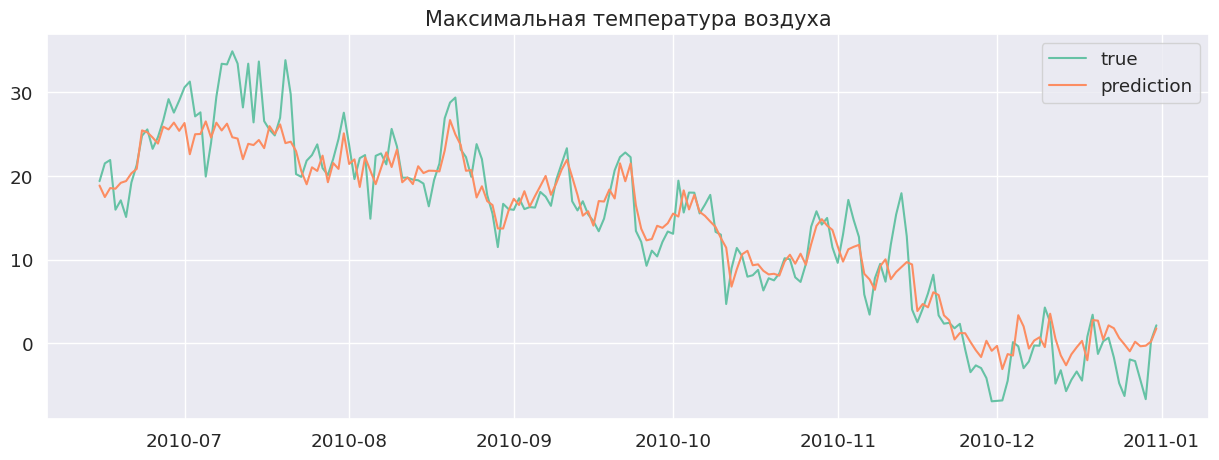

In [83]:
plot_results(final['target'][530:], predict, plot_conf_int=False)

Мы тут обучились на части данных, так как иначе не хватает памяти, поэтому стоит сравнить с catboost, обученным на той же части, но без доп. признаков: 

In [84]:
cat = CatBoostRegressor()
cat.fit(weather_df_daily_good.drop('target', axis=1)[:530], weather_df_daily_good['target'][:530])
predict = cat.predict(weather_df_daily_good.drop('target', axis=1)[530:730])

Learning rate set to 0.037035
0:	learn: 8.8669522	total: 8.19ms	remaining: 8.18s
1:	learn: 8.6281028	total: 15.6ms	remaining: 7.77s
2:	learn: 8.3937155	total: 23ms	remaining: 7.65s
3:	learn: 8.1916406	total: 30.2ms	remaining: 7.51s
4:	learn: 7.9616088	total: 39ms	remaining: 7.77s
5:	learn: 7.7400326	total: 45.8ms	remaining: 7.59s
6:	learn: 7.5257738	total: 52.6ms	remaining: 7.47s
7:	learn: 7.3302378	total: 59.5ms	remaining: 7.38s
8:	learn: 7.1572350	total: 66.5ms	remaining: 7.32s
9:	learn: 6.9755395	total: 73.4ms	remaining: 7.27s
10:	learn: 6.8010252	total: 80.5ms	remaining: 7.23s
11:	learn: 6.6289399	total: 87.2ms	remaining: 7.18s
12:	learn: 6.4714343	total: 93.8ms	remaining: 7.13s
13:	learn: 6.3160747	total: 101ms	remaining: 7.08s
14:	learn: 6.1684894	total: 107ms	remaining: 7.05s
15:	learn: 6.0117231	total: 114ms	remaining: 7.02s
16:	learn: 5.8614742	total: 121ms	remaining: 7s
17:	learn: 5.7287322	total: 128ms	remaining: 6.96s
18:	learn: 5.5938258	total: 134ms	remaining: 6.94s
19:	l

In [85]:
add_results_in_comparison_table('catboost_on_reduced_data', weather_df_daily_good['target'][530:730], predict)

method        MSE       MAE      SMAPE     MedAE
0               baseline_horizon_1  11.368181  2.583306  30.244208  2.070000
1               baseline_horizon_2  16.734771  3.136148  35.871218  2.440000
2               baseline_horizon_3  19.968890  3.467079  39.257602  2.740000
3                         catboost   7.066861  2.010571  24.684209  1.628357
4  catboost_with_a_lot_of_features  11.094890  2.529889  39.988222  2.032277
5         catboost_on_reduced_data   8.890286  2.273989  34.798692  1.814774

Ну, значит нам не помогло и дополнительные фичи нам только мешают

**Выводы:** видимо мы добавили слишком много фичей и они мешают модели хорошо предсказывать, так что оставляем все как было. В целом, ручное добавление фичей обычно эффективнее, если разбираться в теме и понимать какие фичи действительно стоит добавить

## 5. ARIMA-подобные модели

Обучим модель ARIMA, 
* используя сопутствующие временные ряды в качестве экзогенных факторов,
* используя знания о сезонности,
* подобрав оптимальные гиперпараметры.

In [91]:
# Сразу добавим в экзогенные факторы знание о годовой сезонности. Для этого добавим коэффициенты разложения ряда Фурье (первые два как на семинаре)

# первые слагаемые в ряде Фурье
weather_df_daily_good['sin365'] = np.sin(2 * np.pi * weather_df_daily_good.index.dayofyear / 365.25)
weather_df_daily_good['cos365'] = np.cos(2 * np.pi * weather_df_daily_good.index.dayofyear / 365.25)

# вторые слагаемые в ряде Фурье, поэтому вместо 2pi -> 4pi
weather_df_daily_good['sin365_2'] = np.sin(4 * np.pi * weather_df_daily_good.index.dayofyear / 365.25)
weather_df_daily_good['cos365_2'] = np.cos(4 * np.pi * weather_df_daily_good.index.dayofyear / 365.25)

In [149]:
weather_df_daily_good[['sin365', 'cos365', 'sin365_2', 'cos365_2']].head()

sin365    cos365  sin365_2  cos365_2
Date                                              
2009-01-01  0.017202  0.999852  0.034398  0.999408
2009-01-02  0.034398  0.999408  0.068755  0.997634
2009-01-03  0.051584  0.998669  0.103031  0.994678
2009-01-04  0.068755  0.997634  0.137185  0.990545
2009-01-05  0.085906  0.996303  0.171177  0.985240

In [96]:
X_train, Y_train = weather_df_daily_good[:-365].drop(labels=['target'], axis=1), target[:-365]
X_test, Y_test = weather_df_daily_good[-365:].drop(labels=['target'], axis=1), target[-365:]

In [134]:
arima_model = pm.auto_arima(y=Y_train, exogenous=X_train, seasonal=True)

In [135]:
y_arima_forecast, conf_int_exog = arima_model.predict(
    n_periods=365, 
    exogenous=X_test,
    return_conf_int=True, 
    alpha=0.05
)

Обучите модель, посчитайте ее качество и постройте график прогноза *вместе с предсказательным интервалом*.

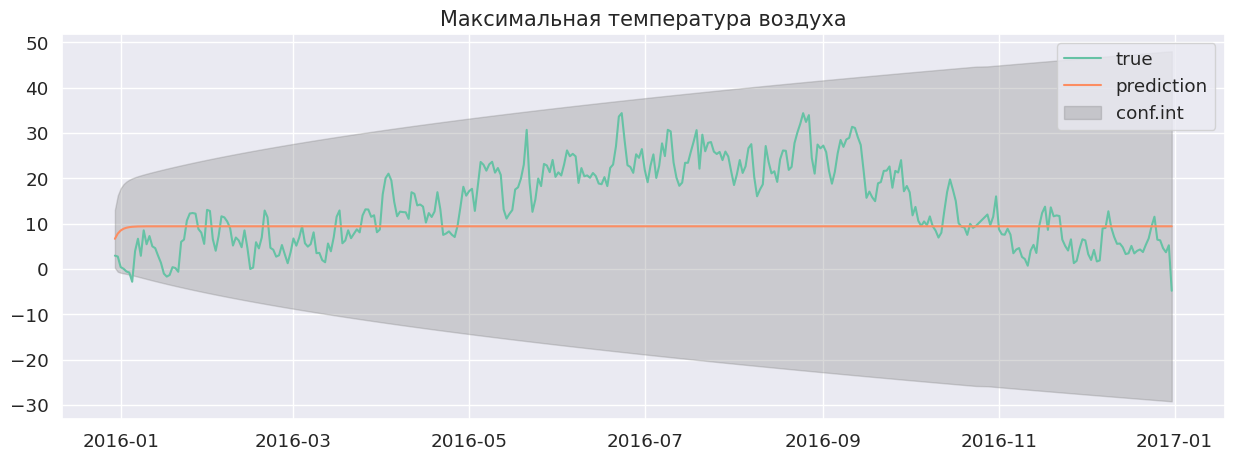

In [136]:
plot_results(Y_test, y_arima_forecast, plot_conf_int=True,
             left_bound=conf_int_exog.T[0],
             right_bound=conf_int_exog.T[1])

Почему-то модель не смогла уловить годовую сезонность, не смотря на то, что коэффициенты ряда Фурье все равно были добавлены. Пробовал вручную задать в начале m = 365, но как и было сказано выше, это заняло очень много времени и я по итогу не дождался результатов

In [137]:
add_results_in_comparison_table('ARIMA', Y_test, y_arima_forecast)

method        MSE       MAE      SMAPE     MedAE
0  baseline_horizon_1  11.368181  2.583306  30.244208  2.070000
1  baseline_horizon_2  16.734771  3.136148  35.871218  2.440000
2  baseline_horizon_3  19.968890  3.467079  39.257602  2.740000
3            catboost   7.278445  2.029239  24.393827  1.676472
4            NNLinear  10.802511  2.577498  34.265846  2.197401
5               ARIMA  99.964083  8.048745  66.323820  6.235000

Ожидаемо плохие метрики, так как модель предсказала просто среднее

In [138]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2554
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -6643.805
Date:                Fri, 21 Apr 2023   AIC                          13295.609
Time:                        10:59:08   BIC                          13318.989
Sample:                    01-01-2009   HQIC                         13304.088
                         - 12-29-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5814      0.037     15.897      0.000       0.510       0.653
ma.L1         -0.7274      0.037    -19.517      0.000      -0.800      -0.654
ma.L2         -0.1444      0.025     -5.735      0.000      -0.194      -0.095
sigma2        10.6616      0.277     38.554      0.000      10.120      11.204
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                32.74
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                            -0.14
Prob(H) (two-sided):                  0.16   Kurtosis:                         3.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Видим какие P (параметр в AR), D (Параметр для приведения ряда к стационарному, а именно сколько diffs надо сделать) и Q (параметр в AR) подобрала модель: 1,1,2. В данном случае модель посчитала, что после дифференцирования ряда один раз, он становится стационарным (что, кстати, более менее логично, так как значения температуры не сильно отличаются изо дня в день, то есть разности скорее всего как-то колеблются в нуле, то есть ряд похож на стационарный). Можем еще обратить внимание на значения колонки ‘P>|z|’ - это P-values и они все нулевые для коэффициентов AR1, MA1 и MA2. Это означает, что они важны по мнению модели

Обучим модель TBATS, используя знания о сезонности. Выполним те же операции, что и для ARIMA.

TBATS не поддерживает передачу экзогенных факторов, так что без них, к сожалению

In [139]:
tbats_estimator = TBATS(seasonal_periods=(365.25,), n_jobs=20)
model = tbats_estimator.fit(y=Y_train)

In [140]:
print(model.summary())

Use Box-Cox: False
Use trend: True
Use damped trend: True
Seasonal periods: [365.25]
Seasonal harmonics [1]
ARMA errors (p, q): (0, 0)
Smoothing (Alpha): 1.023612
Trend (Beta): -0.231166
Damping Parameter (Phi): 0.800000
Seasonal Parameters (Gamma): [-1.61007352e-07 -9.91427275e-08]
AR coefficients []
MA coefficients []
Seed vector [-0.07766487  1.02261484 -7.24494645 -1.80978195]

AIC 26072.924685


Видно, что
- ARMA коэффициенты равны 0;
- модель нашла некий тренд (глобальное потепление? :) );
- модель не посчитала важным использовать преобразование Бокса-Кокса.

In [141]:
tbats_forecast, confidence_info = model.forecast(steps=365, confidence_level=0.95)

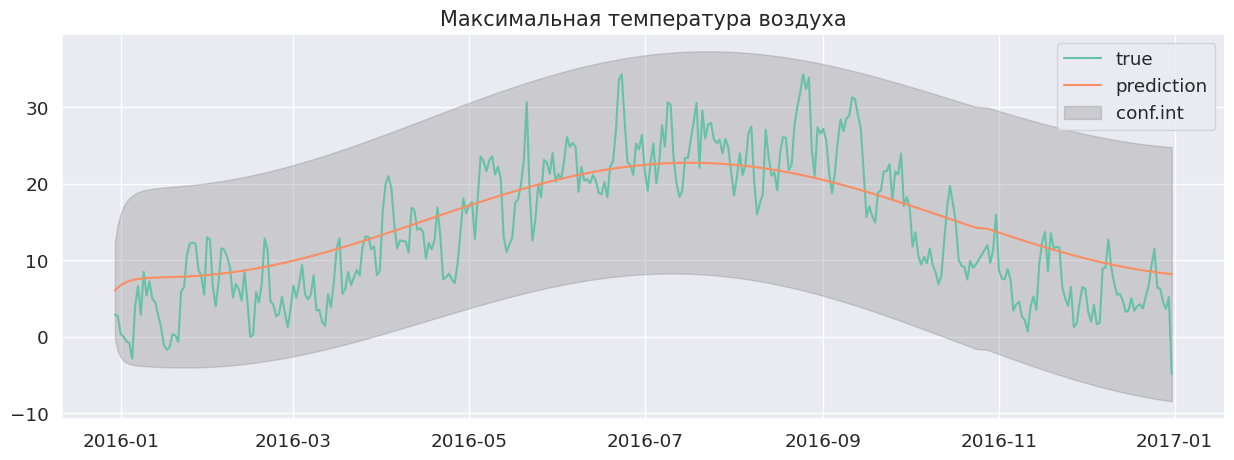

In [142]:
plot_results(Y_test, tbats_forecast, plot_conf_int=True,
             left_bound=confidence_info['lower_bound'],
             right_bound=confidence_info['upper_bound'])

Чтож, из-за того, что в модель не были переданы экзогенные факторы, она справилась не очень: скорее просто усреднила все. Это закономерный результат, так как это все-таки не продажи в магазине, которые мало от чего зависят. Погода же зависит от многих факторов, поэтому истинные значения так колеблются, а наша модель не знает про эти факторы, следовательно, просто пытается как-то усреднить ответы за все годы

In [143]:
add_results_in_comparison_table('TBATS', Y_test, tbats_forecast)

method        MSE       MAE      SMAPE     MedAE
0  baseline_horizon_1  11.368181  2.583306  30.244208  2.070000
1  baseline_horizon_2  16.734771  3.136148  35.871218  2.440000
2  baseline_horizon_3  19.968890  3.467079  39.257602  2.740000
3            catboost   7.278445  2.029239  24.393827  1.676472
4            NNLinear  10.802511  2.577498  34.265846  2.197401
5               ARIMA  99.964083  8.048745  66.323820  6.235000
6               TBATS  25.896769  4.166488  41.141047  3.725374

**Выводы:**

## 6. Итоговое сравнение

В общем то, я ее уже строил, но выведу еще раз

In [144]:
compare_table

method        MSE       MAE      SMAPE     MedAE
0  baseline_horizon_1  11.368181  2.583306  30.244208  2.070000
1  baseline_horizon_2  16.734771  3.136148  35.871218  2.440000
2  baseline_horizon_3  19.968890  3.467079  39.257602  2.740000
3            catboost   7.278445  2.029239  24.393827  1.676472
4            NNLinear  10.802511  2.577498  34.265846  2.197401
5               ARIMA  99.964083  8.048745  66.323820  6.235000
6               TBATS  25.896769  4.166488  41.141047  3.725374

Самой лучшей моделью у меня вышел catboost. Он показал результаты лучше, чем тупое предсказание последней увиденной температурой. Вот графики для этой модели (все графики для кадой модели уже строились, но почему бы не построить еще раз)

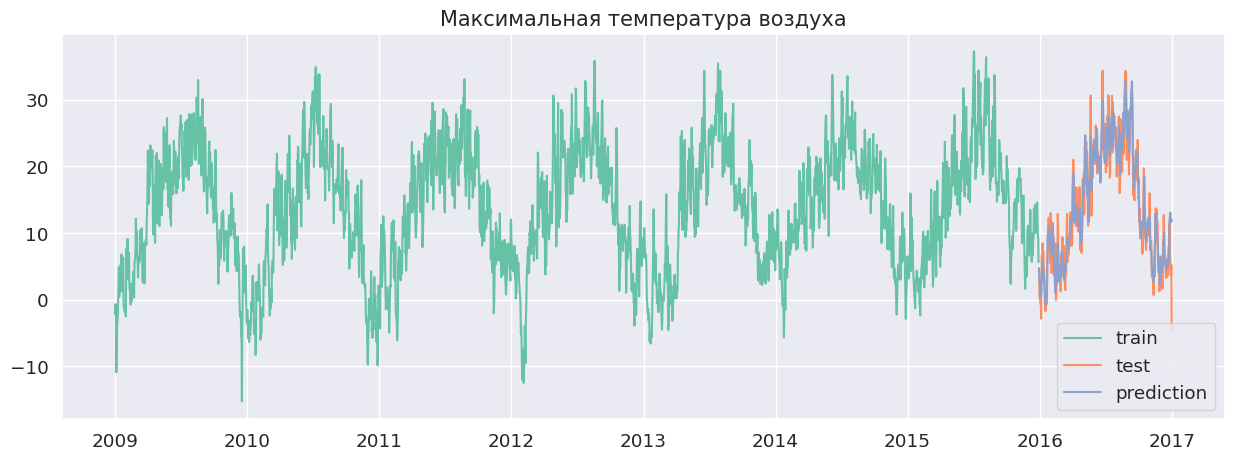

In [145]:
plt.figure(figsize=(15, 5))
plt.title('Максимальная температура воздуха', fontsize=15)
plt.plot(Y_train, label='train')
plt.plot(Y_test, label='test')
plt.plot(Y_test.index, predicted, label='prediction')
plt.legend()
plt.show()

 **Вывод**: для многих временных рядов важны экзогенные факторы, и если их не учитывать, то предсказания будут плохими. Поэтому у нас и вышло, что не самая продвинутая, но использующая экзогенные факторы, модель показала один из лучших результатов. Поздравляем catboost :)